# What to do with Curved Distributions

Welcome to a simple tutorial on what to do when you encounter "curved" distributions, when running MCMC. The tutorial could be roughly divided in 3 parts:
1) Plotting tools
2) What happens when running simple MCMC algorithms on curved distributions
3) What happens when running smart MCMC algorithms on curved distributions, and what algorithms are smart enough.

Throughout the tutorial we will use the Hybrid Rosenbrock distribution to demonstrate some interesting results and good practices.

This tutorial contains quite a lot of useful tools for MCMC, which is available under the GPL 3 licence. Feel free to use them in your work, and if you do, consider citing my work as explained in the README file of this github repository. Thank you!



p.s. I deliberately set the size of all the MCMC sample to be quite small, otherwise they take more than a few moments to run. Feel free to change it to see the effect on the plots. You can always stop the computation with the control at the top of the notebook.

## 0) Load some useful packages ##

In [4]:
library(IDPmisc) #plots
#library(coda) #effectiseSize

library(repr) #to make plots bigger
options(repr.plot.width=15, repr.plot.height=15) #to actually make the plots bigger

library(pracma) #for coth function in sMMALA

library(rstan)
library(devtools) #needed for Stan

## 1) Plotting tools ##

First of all, how do you assess whether your posterior has a curved shape? Normally, people do an "exploratory" MCMC run with a simple algorithm, like a Random Walk Metropolis, and plot the results. Looking at the traceplots can sometimes reveal elements of the shape of the distributions, but the best way is to look at pariwise plots between each component of the target posterior.

Let us first create some synthetic data. Below, the basic R function *pairs()* shows various scatter plots of the 2d marginals of your MCMC sample.

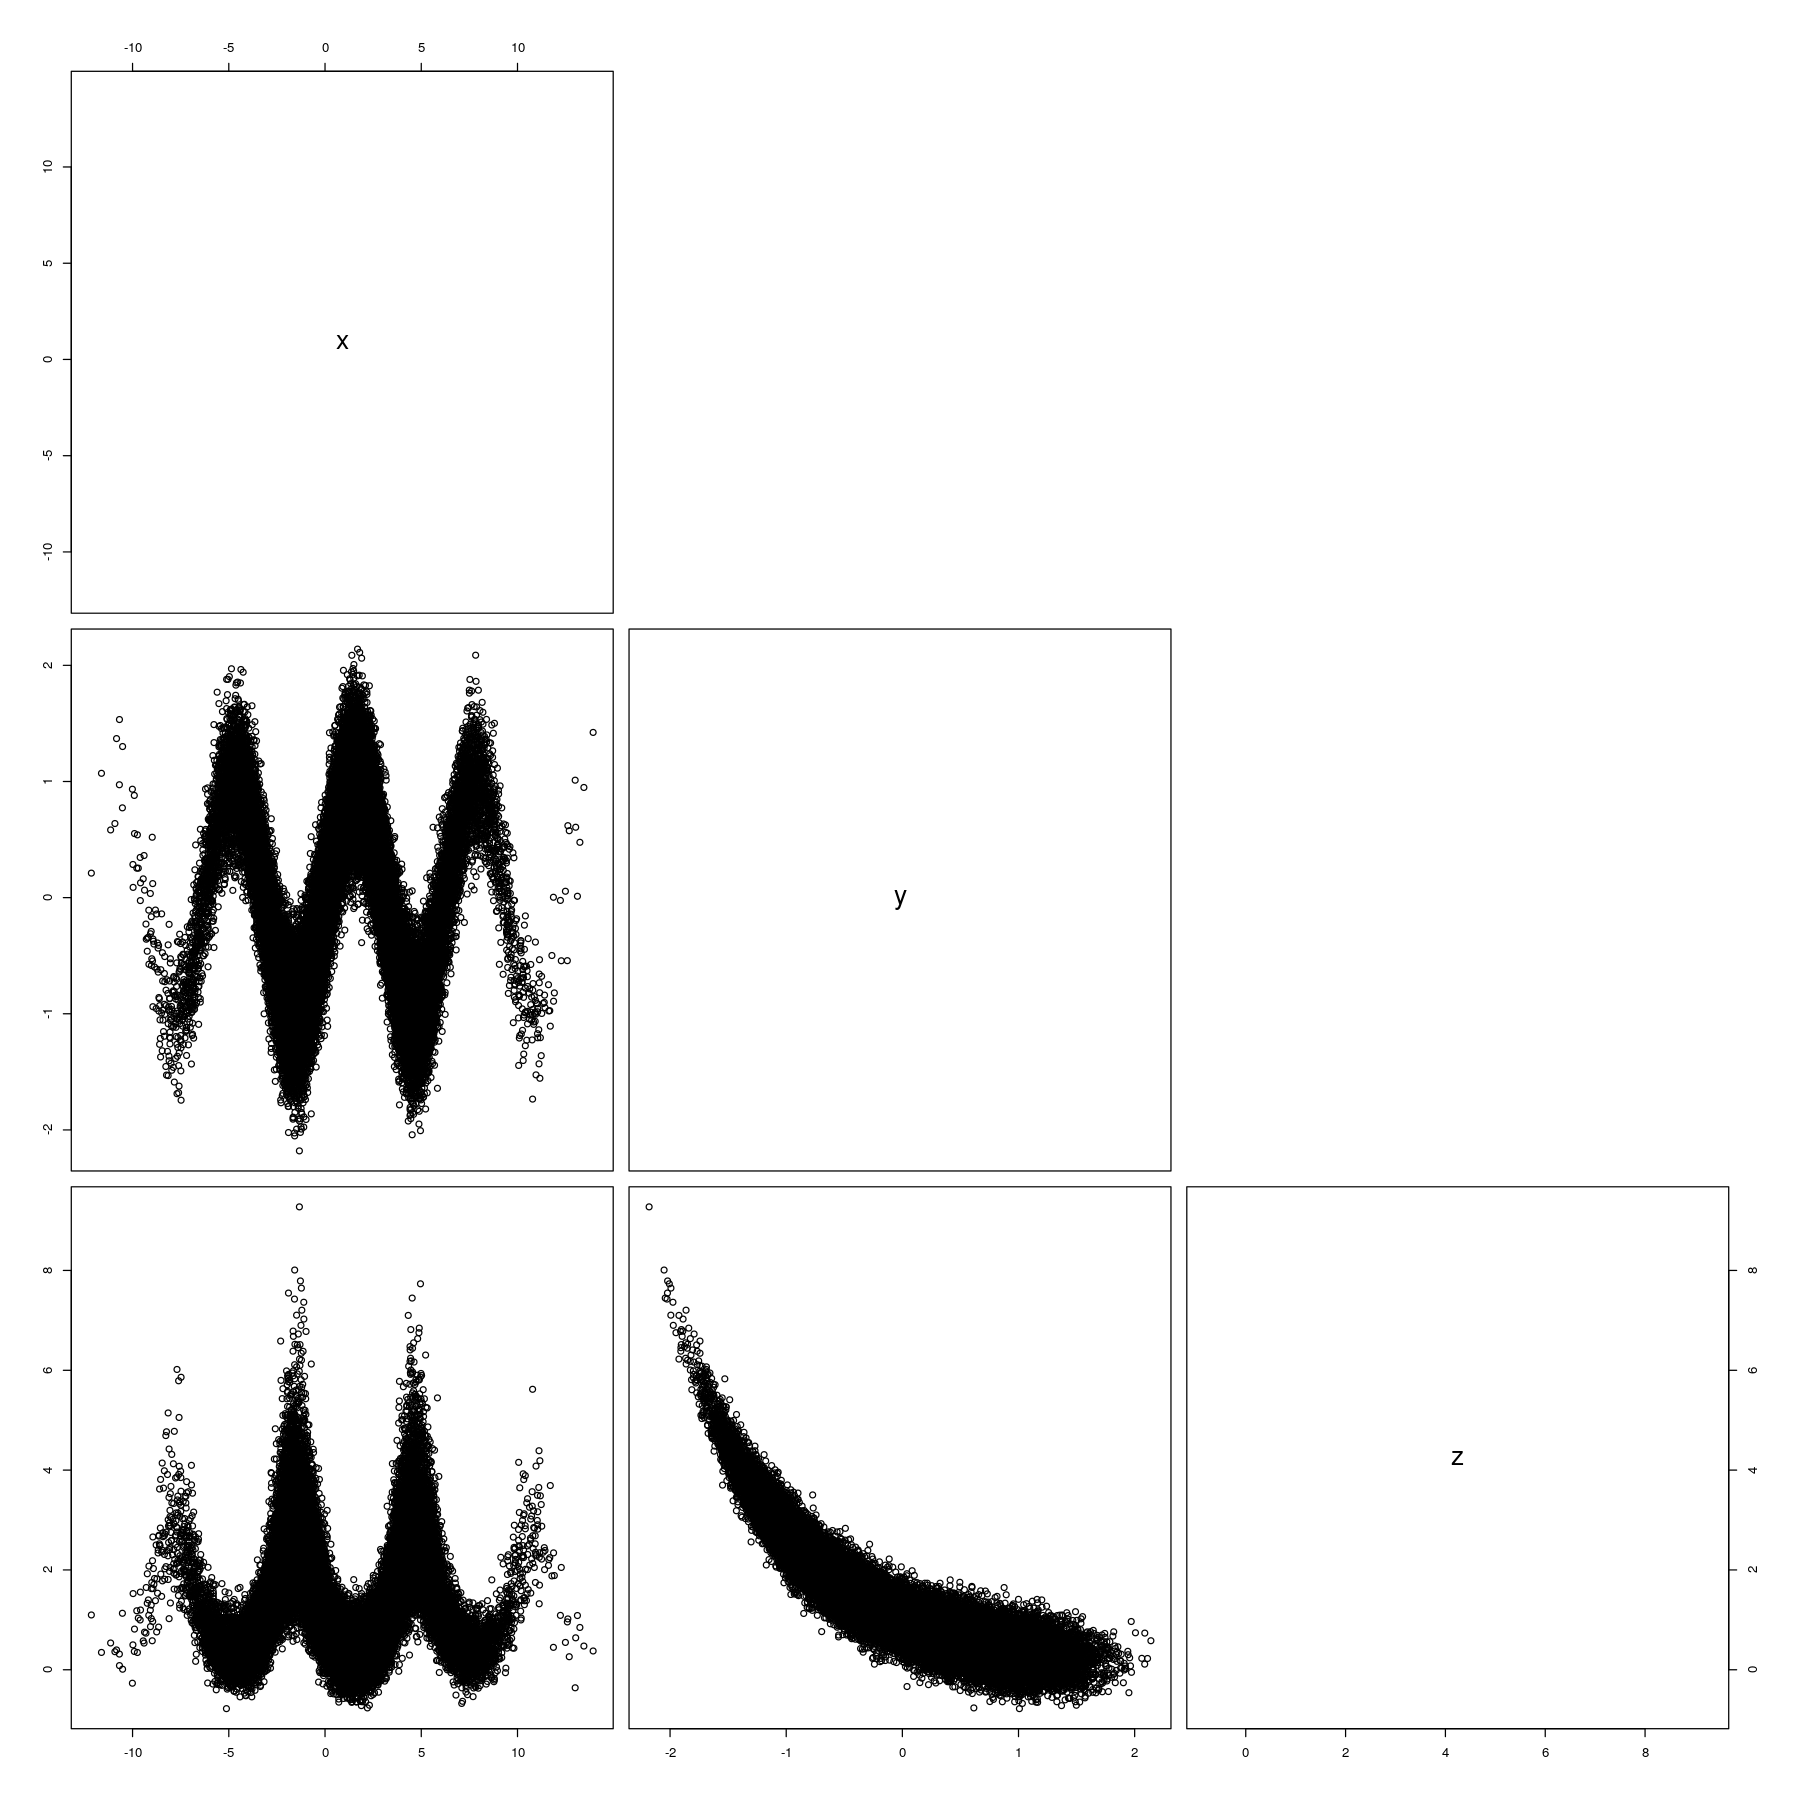

In [3]:
n=5e+4
a=1/20
b=100/20
mu=1

x=rnorm(n, mu, 1/sqrt(2*a))
y=rnorm(n, sin(x), 1/sqrt(2*b))
z=rnorm(n, exp(-y), 1/sqrt(2*b))


pairs(cbind(x,y,z), upper.panel=NULL)

While *pairs()* does not show the elevation of the distribution, the function *ipairs()* from the package **IDPmisc** plots proper 2d histograms with user given bin size, and shows the elevation with colour.

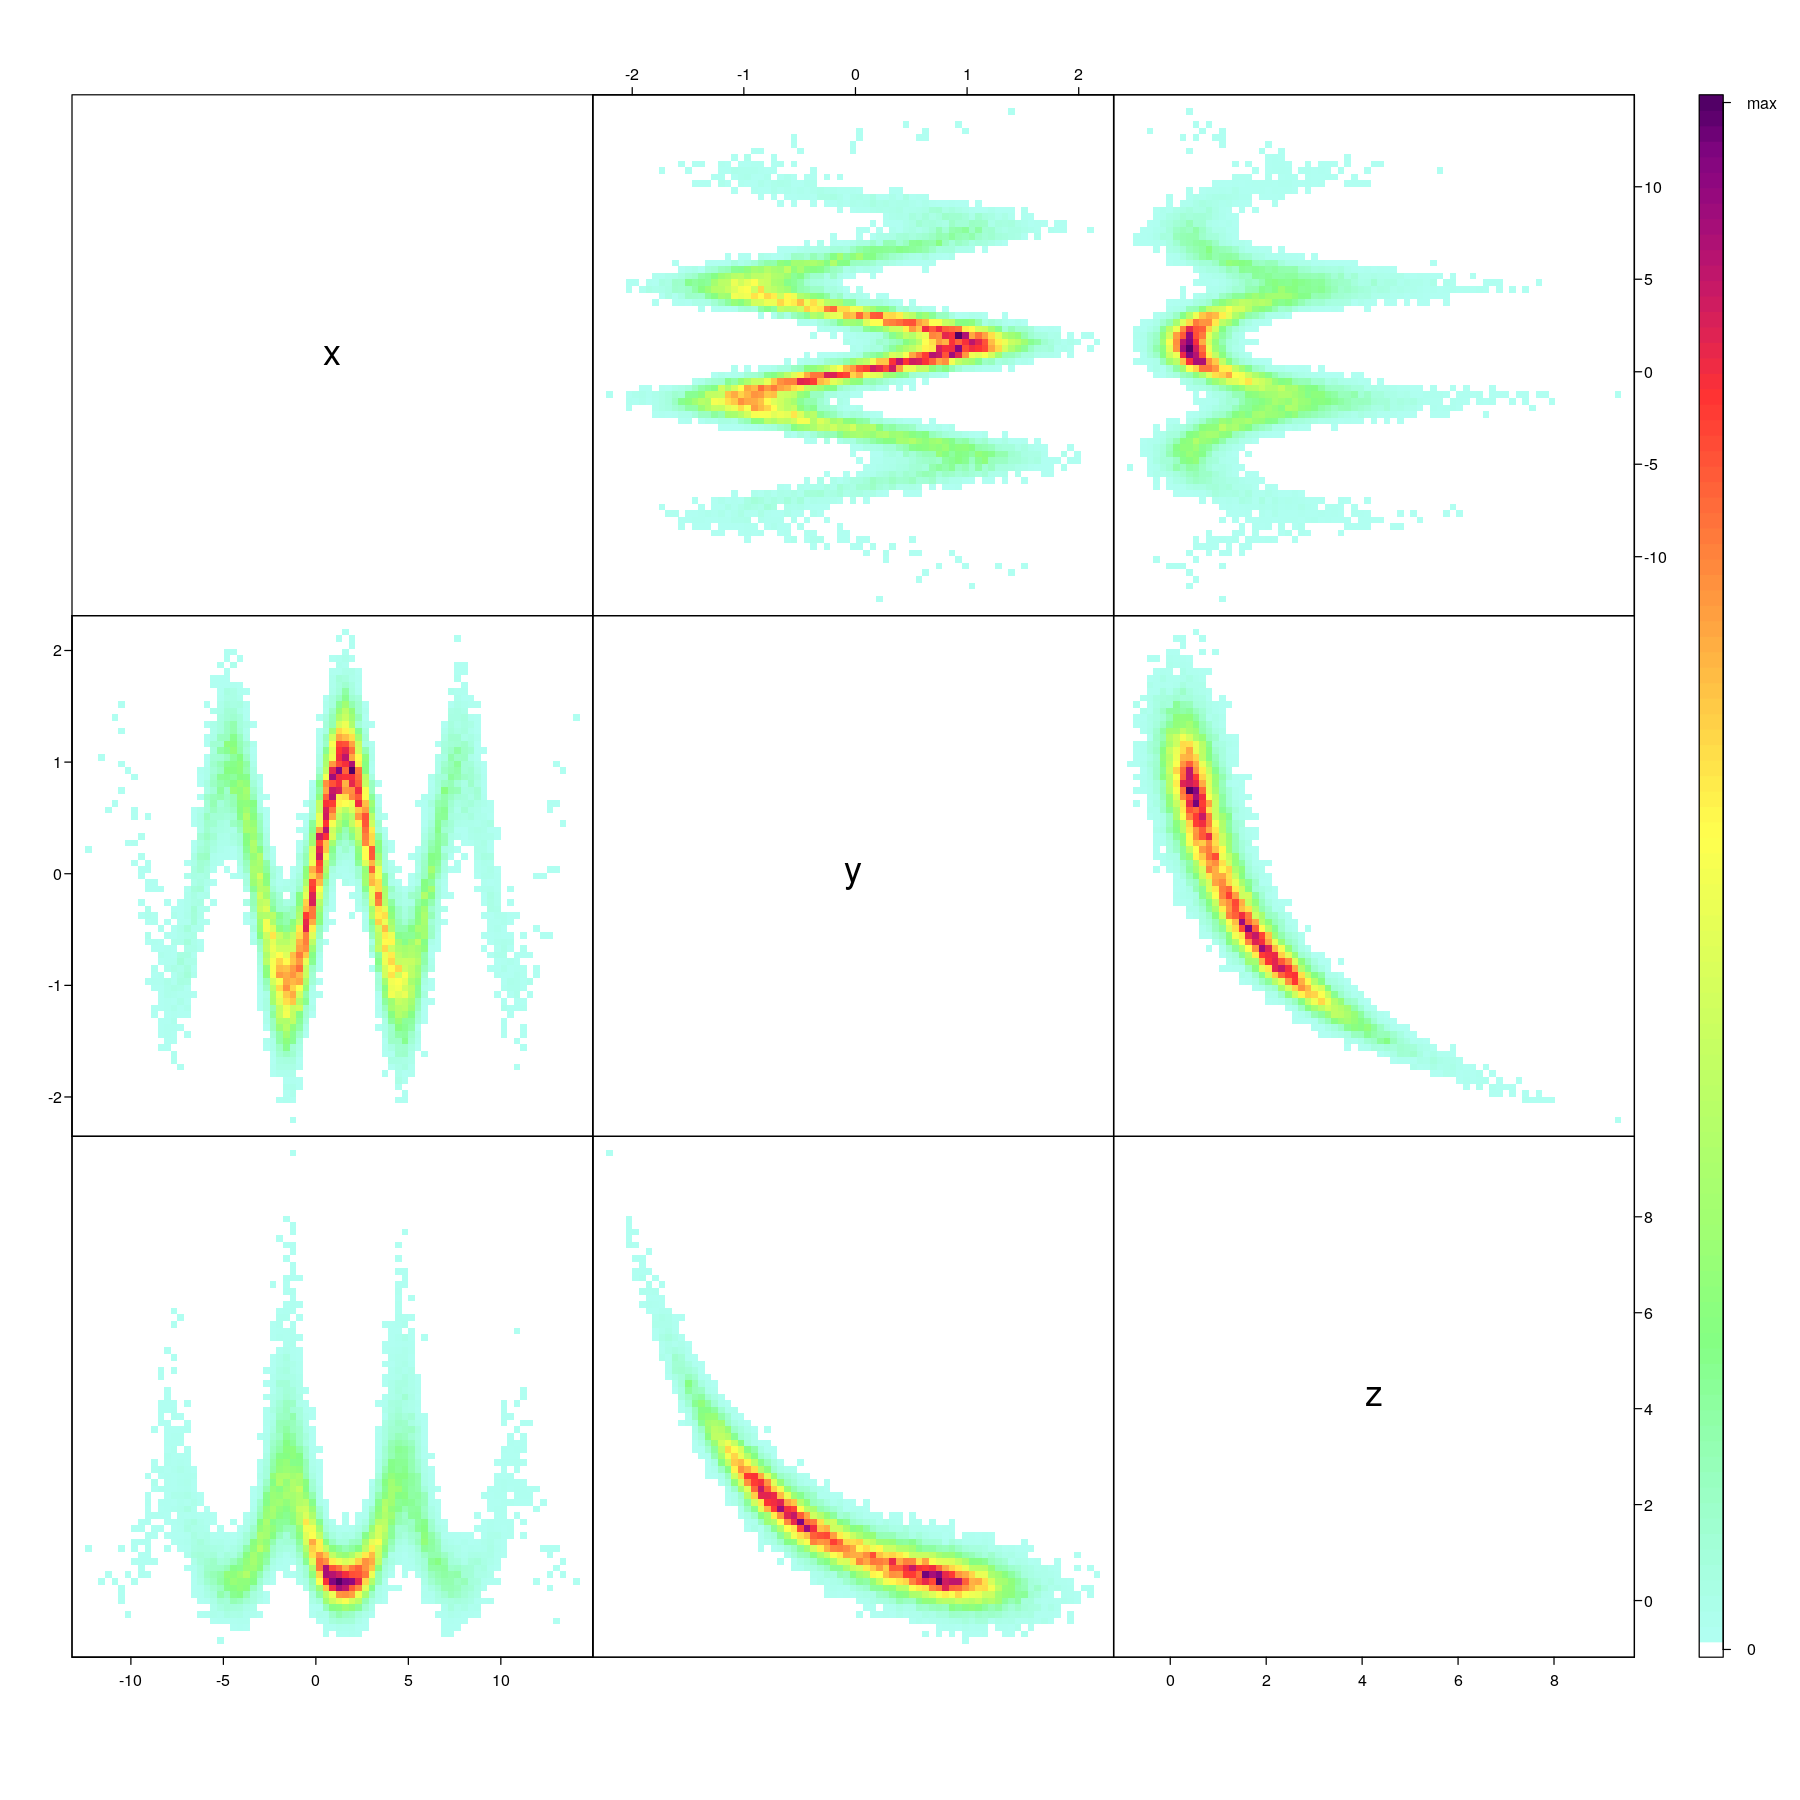

In [4]:
ipairs(cbind(x,y,z), pixs=.5)

The following is what I tend to use. It's custome made, hacked together from various sources, including function in the IDPmisc package.

skipped level 0.3 
skipped level 0.2 
skipped level 0.1 


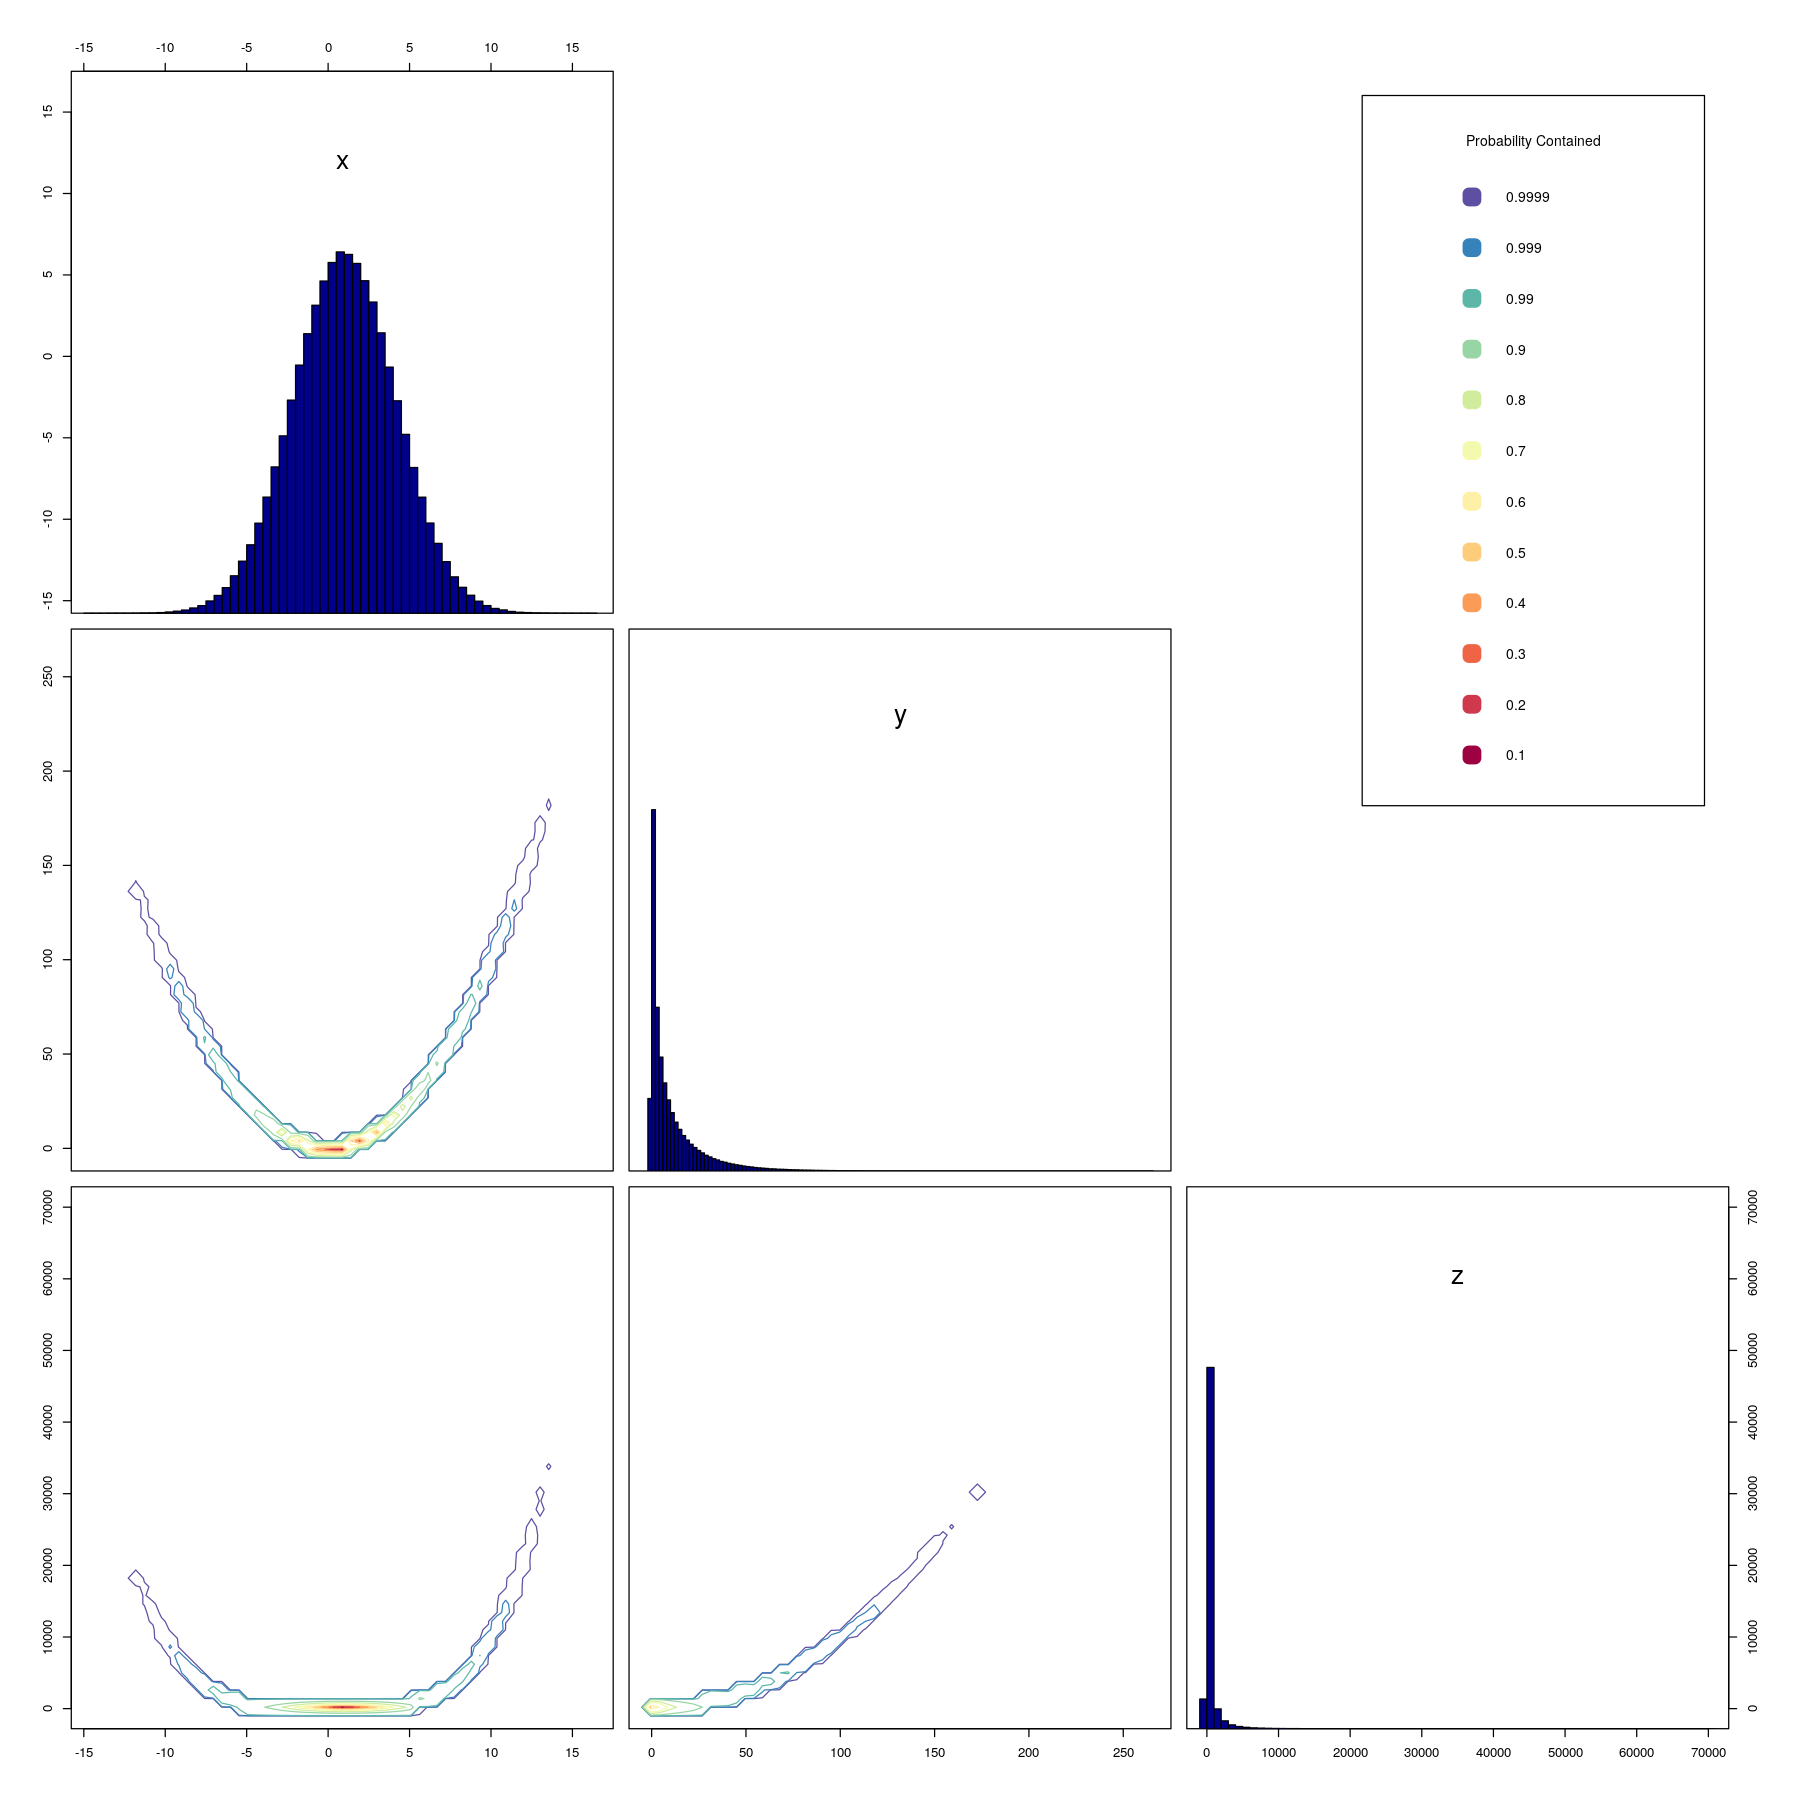

In [5]:
library(IDPmisc)

panel.hist2 <- function(x, ...)
{
	usr <- par("usr"); on.exit(par(usr))
	par(usr = c(usr[1:2], 0, 1.5) )
	h <- hist(x, plot = FALSE)
	breaks <- h$breaks; nB <- length(breaks)
	
	h <- hist(x, breaks = nB*4, plot = FALSE) #use 4 times the breaks!!!!!!!!
	breaks <- h$breaks; nB <- length(breaks)
	y <- h$counts; y <- y/max(y)
	rect(breaks[-nB], 0, breaks[-1], y, col="blue4", ...)
	#axis(1, tick=F, line=-1)
	#axis(1, labels=F, lwd=.5)
}

myBetterPairs <- function(YourData, resol=1, lab=NULL){ #label, conf_contour2,  no upper panel
	if ( is.null(lab) ){
		return(pairs(YourData, lower.panel=function(...) {par(new=TRUE); conf_contour2(histMat <- myImage(matrix(c(...),dim(YourData)[1],2), pixs=resol, matrix = T), alpha=clevels, cl=r, lab=F, add = T)}, diag.panel=panel.hist2, upper.panel=NULL))
	} else {
		return(pairs(YourData, lower.panel=function(...) {par(new=TRUE); conf_contour2(histMat <- myImage(matrix(c(...),dim(YourData)[1],2), pixs=resol, matrix = T), alpha=clevels, cl=r, lab=F, add = T)}, diag.panel=panel.hist2, upper.panel=NULL, labels = lab))
	}
}

myImage = function (x, y = NULL, pixs = 1, zmax = NULL, ztransf = function(x) {x}, colramp = IDPcolorRamp, factors = c(FALSE, FALSE), matrix = FALSE) 
{
	## function hacked from IDPmisc, as I needed the values and not the histogram ##
	#library(plotly)
	#library(pracma) #looks like not needed
	
    xy <- NaRV.omit(getXY(x, y))
    factors <- factors | sapply(xy, is.factor)
    xy <- sapply(xy, as.numeric)
    pixs <- (pixs/10)/2.54
    usr <- par("usr")
    if (factors[1]) {
        bx <- seq(min(xy[, 1] - 0.25), max(xy[, 1] + 0.25), length.out = 2 * diff(range(xy[, 1])) + 2) #bx and by are bins!
    }
    else {
        bx <- seq(usr[1], usr[2], length.out = round(par("pin")/pixs)[1] + 1)
    }
    if (factors[2]) {
        by <- seq(min(xy[, 2] - 0.25), max(xy[, 2] + 0.25), length.out = 2 * diff(range(xy[, 2])) + 2)
    }
    else {
        by <- seq(usr[3], usr[4], length.out = round(par("pin")/pixs)[2] + 1)
    }
    zz <- ztransf(table(cut(xy[, 1], breaks = bx), cut(xy[, 2], breaks = by)))
    zzmax <- ceiling(max(zz))
    if (is.null(zmax)) zmax <- zzmax
    else zmax <- ceiling(zmax)
    if (zmax < 1 || is.null(zmax)) {stop("zmax must be >= 1 and\n          plot(x,y,...) must have been called before calling this function!\n")}
    if (zzmax > zmax) stop("zmax too small! Densiest aereas are out of range!", call. = FALSE)
    zmax <- max(zmax, 2)
    lbx <- length(bx)
    lby <- length(by)
    xx <- 0.5 * (bx[-1] + bx[-lbx])
    yy <- 0.5 * (by[-1] + by[-lby])
    #image(x = xx, y = yy, zz, col = colramp(zmax), breaks = seq(0.5, zmax + 1, 1), xaxs = "r", yaxs = "r", add = TRUE)
    #box()
    if (matrix) invisible(list(xx,yy,zz,bx,by)) ######outputs list with bins as well
    else invisible(zzmax)
}

conf_contour2 = function(hist2d_obj, alpha, normalise=F, add=F, cl="black", lab=T, Xlim, Ylim) { #flattest, not edge
	## based on drawcontour.R, written by J.D. Forester, 17 March 2008 ##
	znorm <- hist2d_obj[[3]] / ifelse(normalise,sum(hist2d_obj[[3]]),1)
	zdens <- sort(znorm, decreasing=T)
	Czdens <- cumsum(zdens)
	Czdens <- (Czdens/Czdens[length(zdens)]) #normalise levels

	for(cont.level in 1:length(alpha)){
		tmpp = max(which(Czdens<=alpha[cont.level]))
		if( is.infinite(tmpp) ) {
			cat("skipped level",alpha[cont.level],"\n", sep=" ")
			next
		}
    	crit.val <- zdens[tmpp]
    	contour(x=hist2d_obj[[1]], y=hist2d_obj[[2]], z=znorm, levels = crit.val, add=ifelse(add,T,ifelse(cont.level==1,F,T) ), method="flattest", labels = alpha[cont.level], drawlabels = lab, col = cl[cont.level], xlim=Xlim, ylim=Ylim) #edge

	}
}

## Build color palette ##
library(RColorBrewer)
library(colorRamps)

clevels = c(.9999, .999, .99, seq(.9, .1, by=-.1) )

l = length(clevels)
rf <- colorRampPalette(rev(brewer.pal(11,'Spectral')))
#r <- rf(length(pretty(range(histMat[[3]])/sum(histMat[[3]]),l )))
r <- rf(l)
        
        
## Actually do the plot ##
myBetterPairs(cbind(x,y,z), resol=.7 ) #resol=.02

par(xpd=TRUE)
legend("topright", border=r, legend = clevels, horiz = F, pt.lwd=10, col=r, pch=0, cex = .7, inset=.04, title="Probability Contained") #inset=.048
par(xpd=FALSE)
        
#the numbers in the plots are a bit small here in jupyter, but are fine in normal R.

Note how the plots show contours constructed by taking the flattest line going through the bins of the 2d histograms. Using basic KDE without checking its assumptions (which in this case are very much not satisfied) may lead to very wrong pictures. Using contours based on histograms gives lines that are not as smooth as one may want, but it's easier for me to tell when they're over-smoothed. Talk to me if you want to know more about this.

## 2) Basic MCMC on a 2d Rosenbrock

The previous section covered some basic plotting tools. In this section we're going to use those plotting tools and see how a sample from a 2d Rosenbrock distribution looks like when it's taken using a Random Walk Metropolis (RWM) algorithm. 

In the plot below, we show what the true shape of the distribution is. You can play with it and experiment with the jupyter notebook. Change the shape of the distribution by changing the parameters *mu, a, b*. Remember to look at the scales of the distribution on the side of the graph, to get a sense of how long the tails are.

Change the *resol* argument in the function *myBetterPairs()* to get a feeling of what value does not over-smooth nor under-smooth the density.

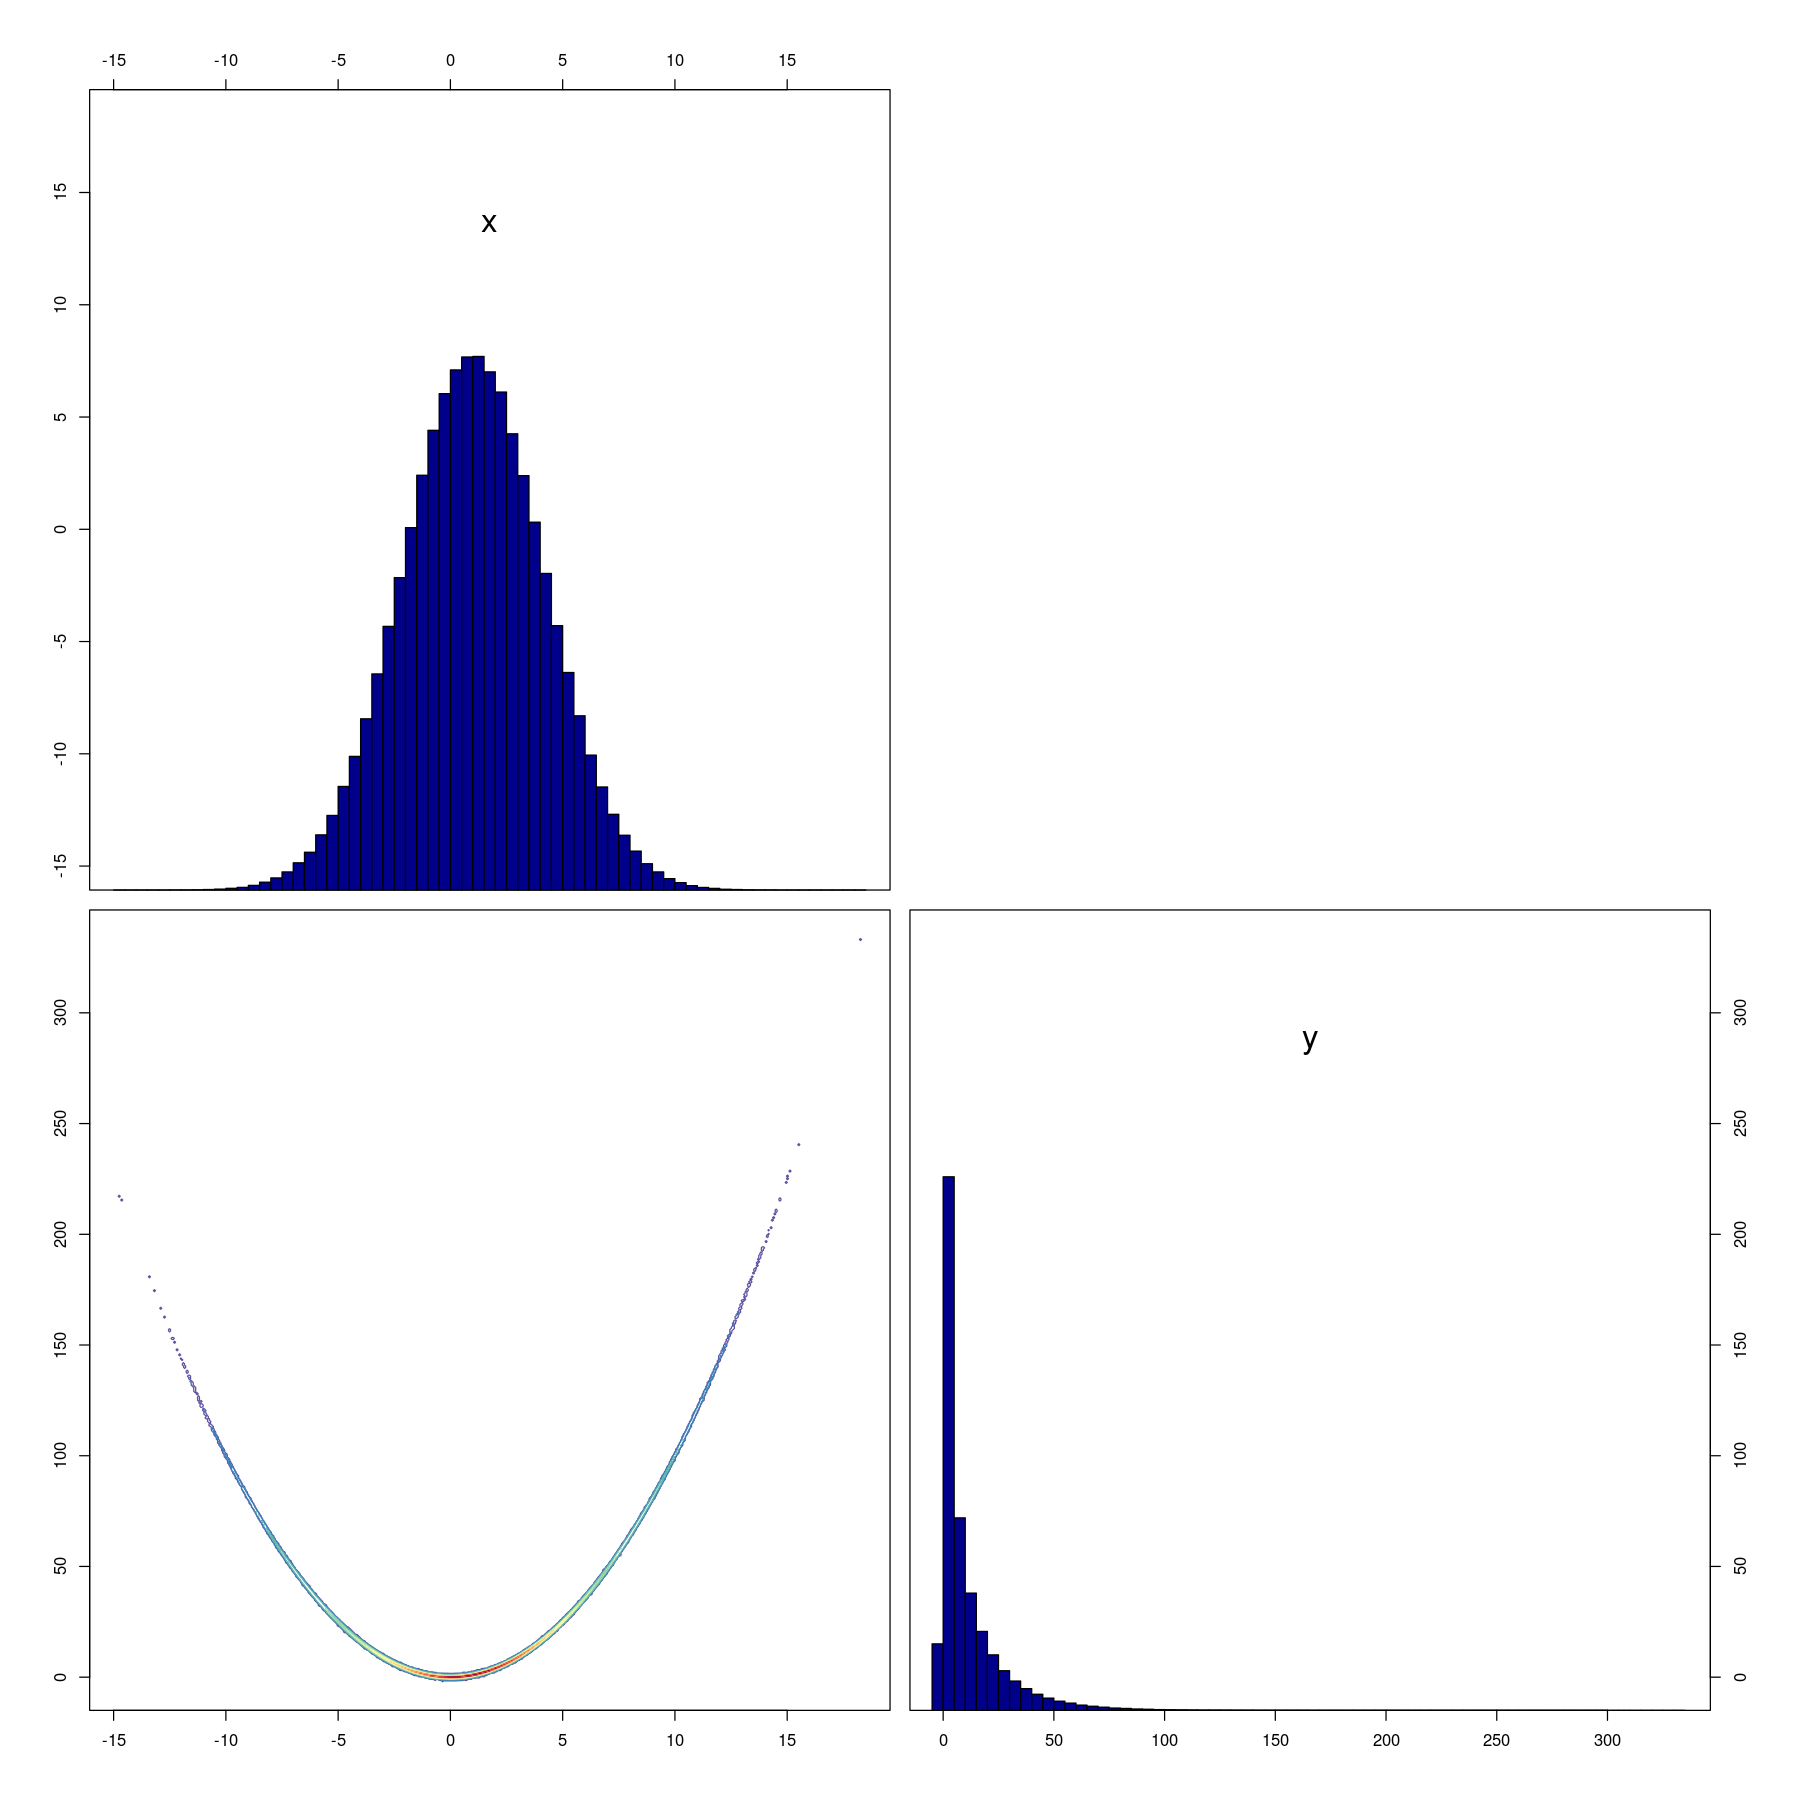

In [6]:
n=1e+6     #number of random iid Monte Carlo samples. Increase if histograms are too jagged. Not too much!
mu=1       #position of the mode along the parabola x^2
a=1/20     #variation *along* the parabola x^2
b=100/20   #variation *around* the parabola x^2

x=rnorm(n, mu, 1/sqrt(2*a)) #draw iid MC samples
y=rnorm(n, x^2, 1/sqrt(2*b))

myBetterPairs(cbind(x,y), resol=.1 ) #plot. Careful not to under- or over-smooth.

The plot above shows the shape of the true distribution. Now let's run a Random Walk Metropolis (a.k.a. a simple MCMC algorithm) and compare the results with the plot above.

Tune the RWM algorithm by changing the step size, to obtain an acceptance of maybe 23-35%. The optimal acceptance is usually between 41% for a one dimensional target, and 23.4% for an infinite dimensional one.

The code just below loads the Random Walk algorithm.

In [7]:
# load the rw function #

rw <- function(target, N, x, step, Sigma=diag(length(x)), thin=1)
{
ptm=proc.time()
cat("Tot run = N*thin = ",N*thin,"\n")
if ( sum(Sigma - diag(length(x)) )==0  ){
	ident=TRUE
} else {
	ident=FALSE
	Sigma.chol <- t( chol(Sigma) )
}
dd=length(x) 
acc=0
samples = matrix(0, N, length(x) )
samples[1,] <- x
run=N*thin
target_prop = target_x = target(x)
for (i in 2:run )
{
	if(i%%(run/10)==0) cat("Progress:",i/run*100,"% \n") #track progress
	
	if (ident) prop <- x + step*rnorm(dd)
	else prop = x + step * Sigma.chol %*% rnorm(dd)
	
	target_prop = target(prop)

	if (runif(1) < exp( target_prop - target_x ) ){
		x <- prop
		acc = acc + 1
		target_x = target_prop
	}
	
	if( (i%%thin)==0 ) samples[i/thin,] = x
}
time=proc.time()-ptm
cat('Run Time',round(time[1]/60,digits=2),'Min','\n')
cat("Acc Rate",acc/run,"\n")
#system(paste("echo Acc",acc/run))
return(list(samples,time[1]))
}

The code below defines the target and runs the Random Walk.

Be careful: the parameter values mu, a, b are those defined just above, at the beginning of this section.

To improve the plot, try increasing the n. of MCMC samples (2nd argument). Not too much, otherwise it will take a long time to run. I think 20 million should take around 1 minute of your time.

If you feel like experimenting, you can try to see if a rotation matrix and/or thinning improve the result at all. See arguments of the *rw()* function defined above.

In [9]:
logTarget1=function(q){-a*(q[1]-mu)^2 -b*(q[2] - q[1]^2)^2 } 
resRW=rw(logTarget1, 1e+6, c(1,1), .4)

Tot run = N*thin =  1e+06 
Progress: 10 % 
Progress: 20 % 
Progress: 30 % 
Progress: 40 % 
Progress: 50 % 
Progress: 60 % 
Progress: 70 % 
Progress: 80 % 
Progress: 90 % 
Progress: 100 % 
Run Time 0.1 Min 
Acc Rate 0.286025 


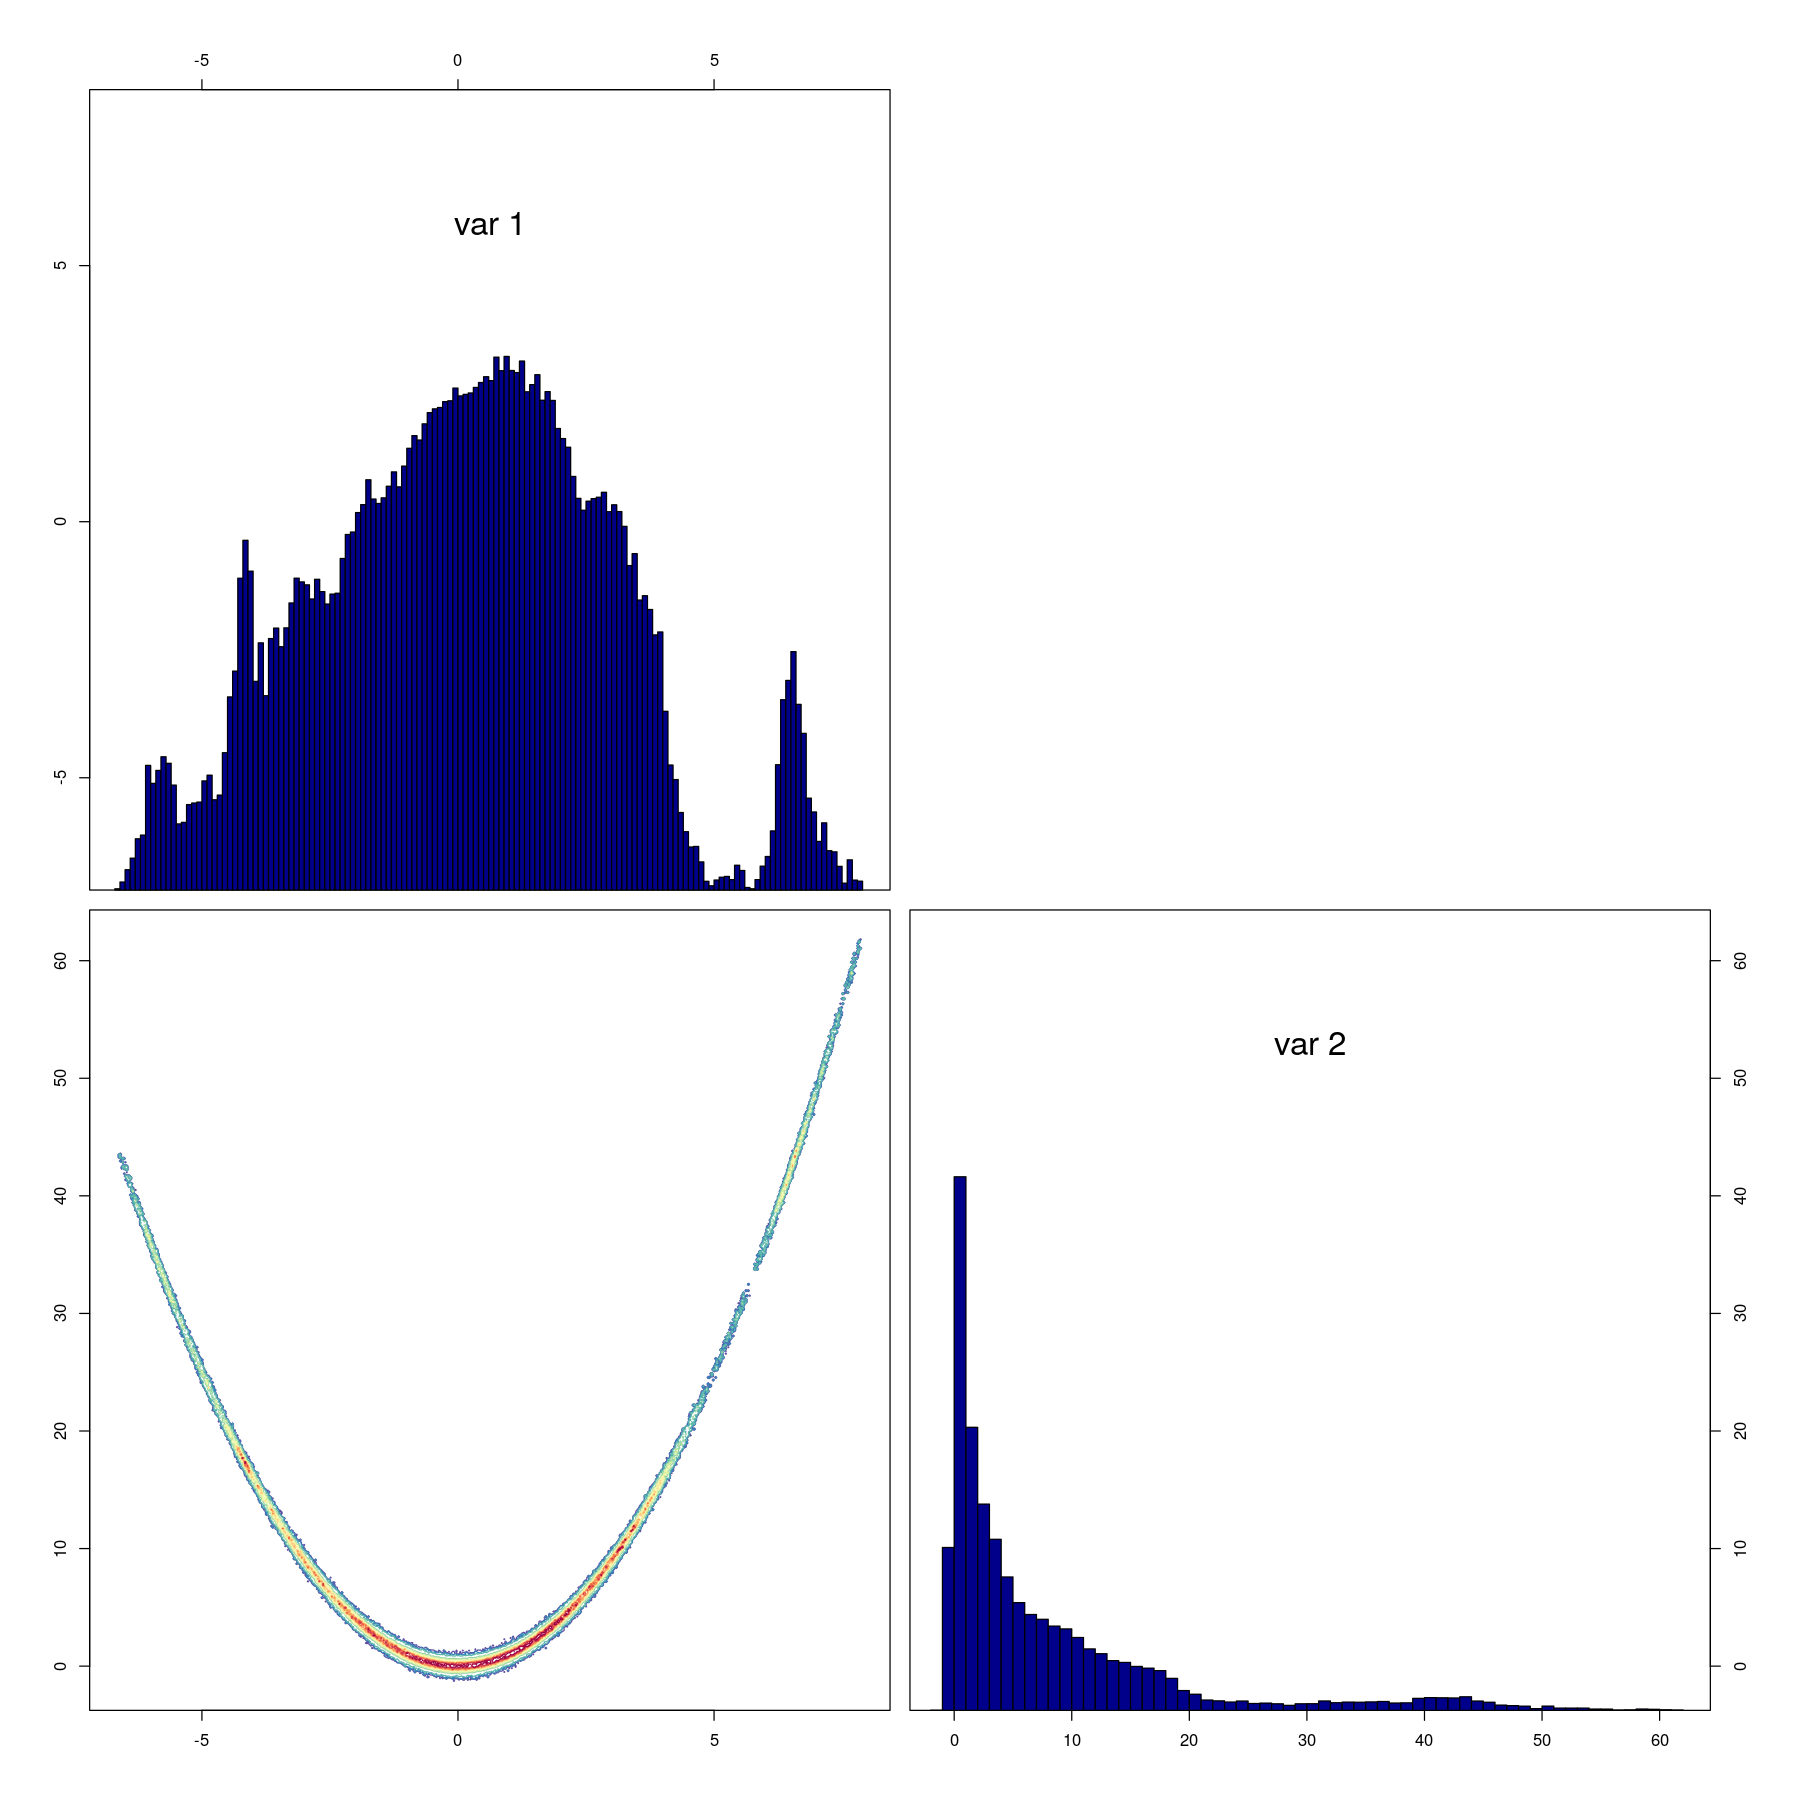

In [10]:
myBetterPairs(resRW[[1]], resol=.1 ) #plot. Careful not to under- or over-smooth.

As you will notice, when comparing the results to the true shape in the plot above, the results do not seem very good, and they get worse at the dimension of the target increases, as showed in the next section. It is normal, the Random Walk Metropolis is not the best algorithm for this kind of targets. However, it clearly shows that the shape is curved. Once you know that, you should be alert and start looking into

1) MCMC convergence tests

2) finding a benchmark model that looks slightly more challenging than your target, and test your current MCMC algorithm to see how biased your sample would be

3) finding other MCMC algorithms that work well on curved targets

4) ... ?

## 3a) Basic MCMC on a 5d Hybrid Rosenbrock

In section 2) we established a workflow using one of the simplest curved distribution, the 2d Rosenbrock. We took and *iid* sample, used our plotting tools to look at its true shape, and visually compared it with the shape we obtained from a Random Walk MCMC sample.

In this section we will follow the same workflow, just with a more complex, 5-dimensional target. Just below, the plot shows the true shape of a 5d Hybrid Rosenbrock with 2 blocks, and 2 layers per block. After that, we'll run some MCMC algorithms, to get a feeling on how well they cope with the extreme features of this density, starting with a Random Walk Metropolis.

skipped level 0.2 
skipped level 0.1 
skipped level 0.1 
skipped level 0.2 
skipped level 0.1 
skipped level 0.2 
skipped level 0.1 
skipped level 0.7 
skipped level 0.6 
skipped level 0.5 
skipped level 0.4 
skipped level 0.3 
skipped level 0.2 
skipped level 0.1 
skipped level 0.2 
skipped level 0.1 


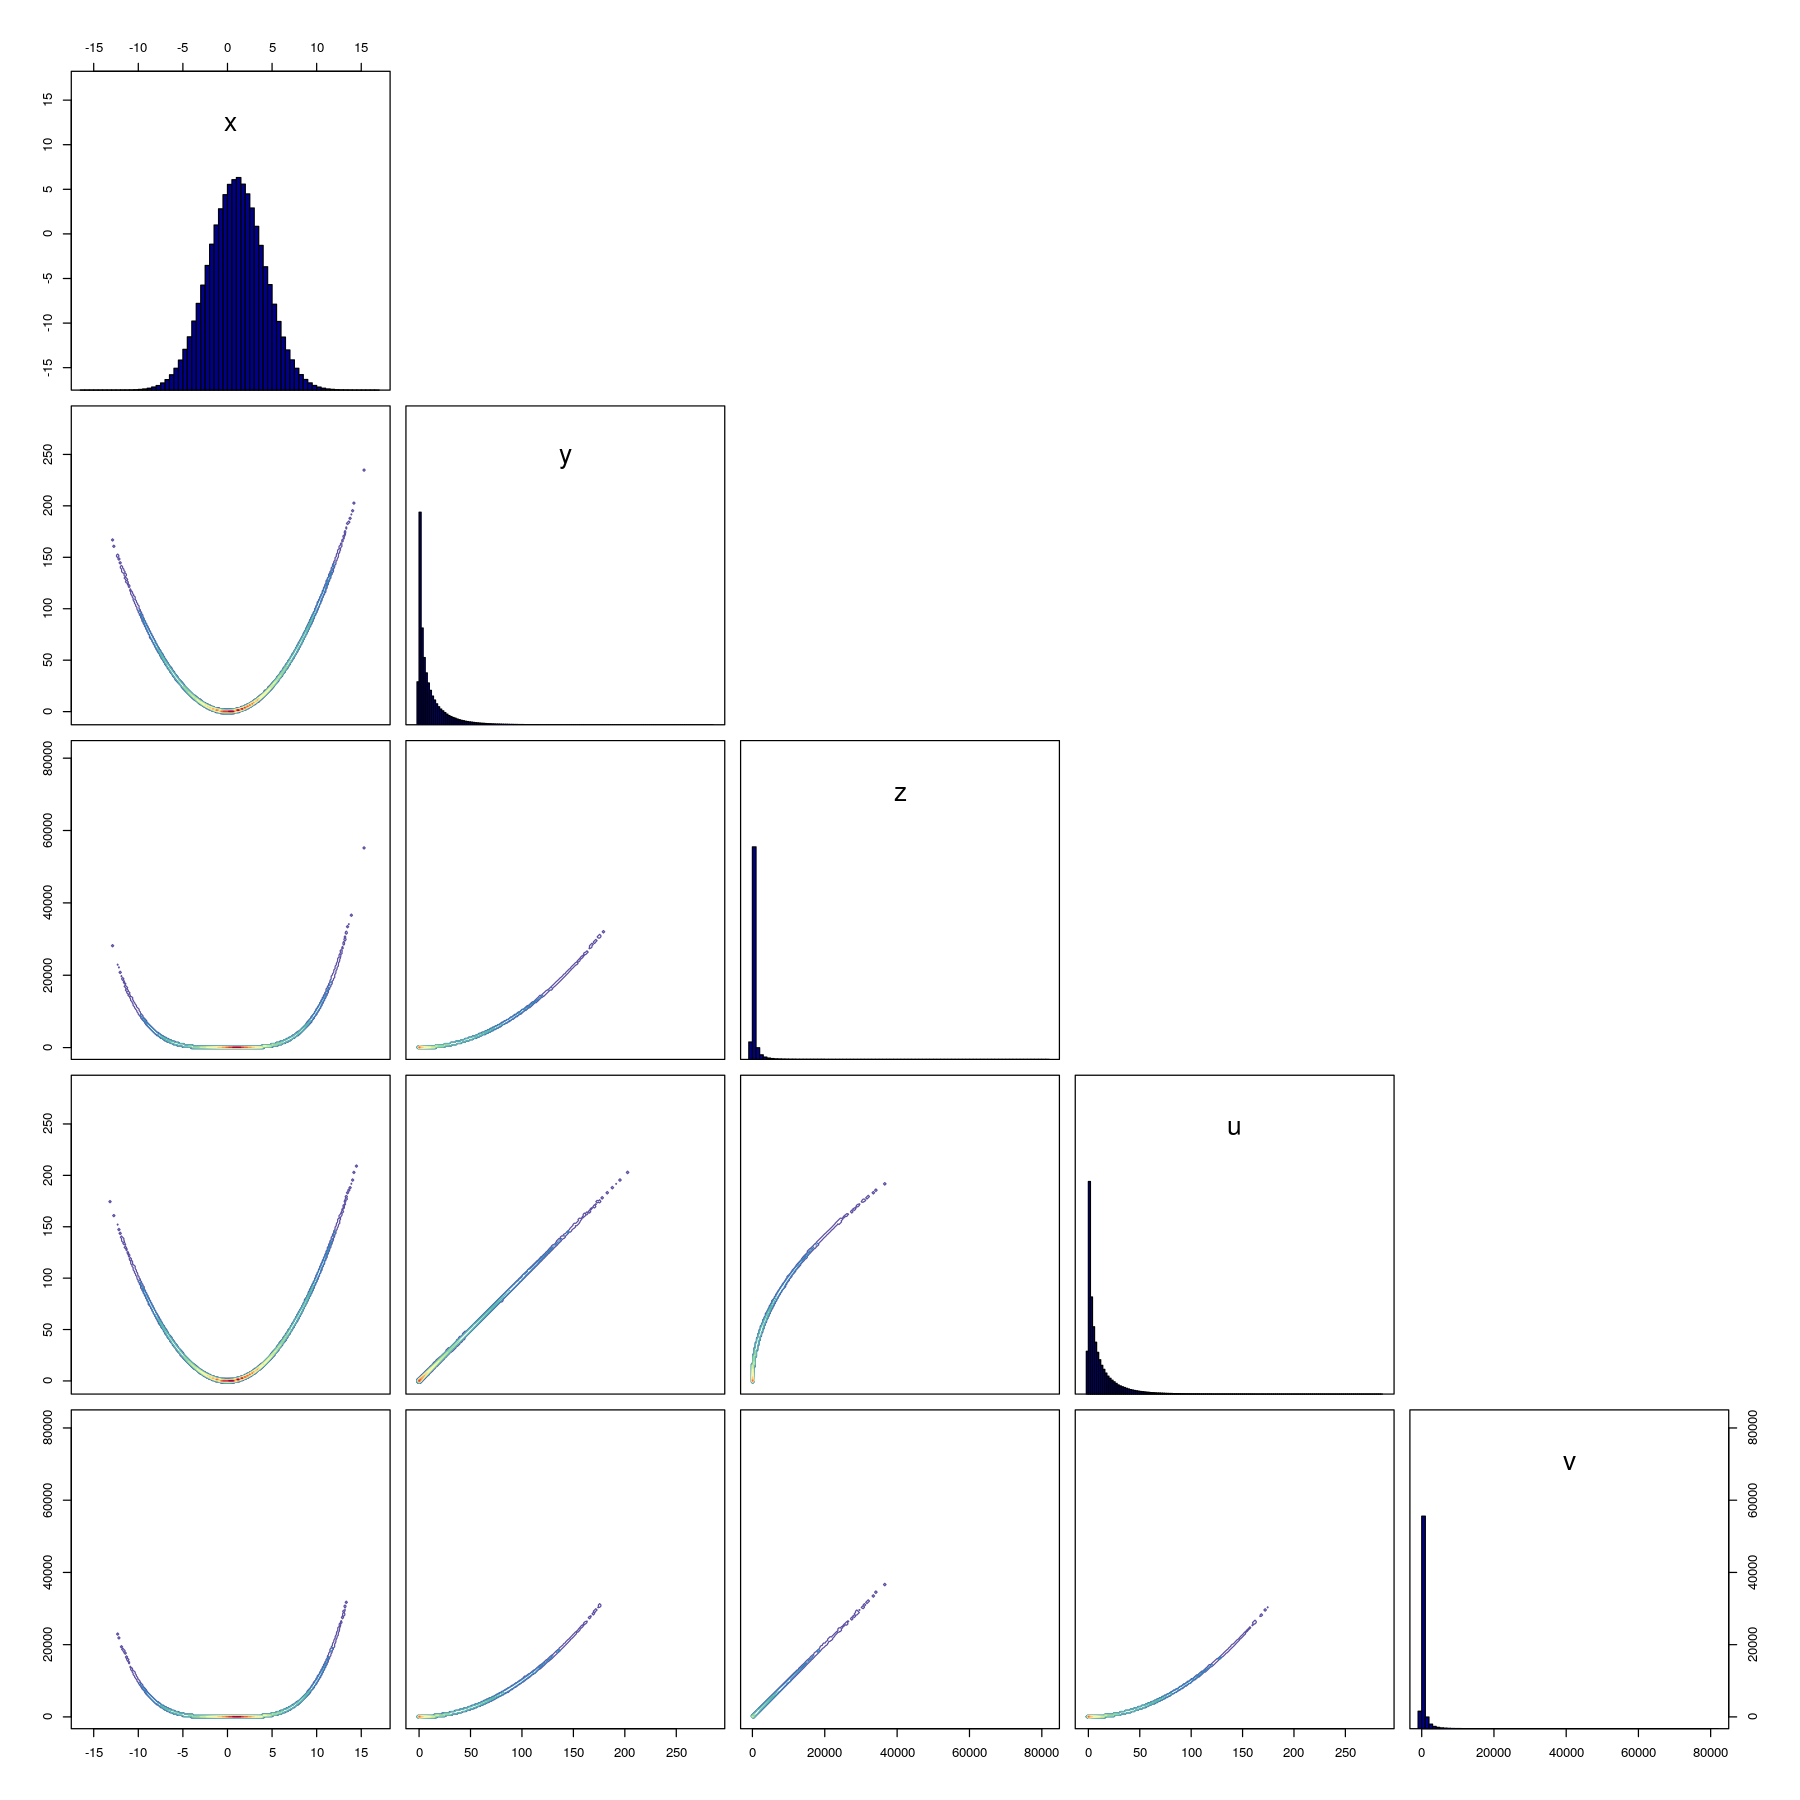

In [6]:
n=1e+6     #number of random iid Monte Carlo samples. Increase if histograms are too jagged. Not too much!
mu=1       #position of the mode along the parabola x^2
a=1/20     #variation *along* the parabola x^2
c=b=100/20   #variation *around* the parabola x^2

x=rnorm(n, mu, 1/sqrt(2*a)) #draw iid MC samples
y=rnorm(n, x^2, 1/sqrt(2*b))
z=rnorm(n, y^2, 1/sqrt(2*c))
u=rnorm(n, x^2, 1/sqrt(2*b))
v=rnorm(n, u^2, 1/sqrt(2*c))

#don't mind the warnings, you're just skipping plotting a contour line because it's too narrow. 
#You'll see from the picture.
options(warn=-1)
myBetterPairs(cbind(x,y,z,u,v), resol=.1 ) #plot. Careful not to under- or over-smooth.
options(warn= 0)

The code below defines the target and runs a Random Walk Metropolis. To see how well it does on this density, visually compare it with the true shape in the plot above.

Be careful: the parameter values mu, a, b are those defined just above, at the beginning of this section.

To improve the plot, try increasing the n. of MCMC samples (2nd argument). Not too much, otherwise it will take a long time to run. I think 20 million should take around 1 minute of your time.

In [17]:
logTarget6=function(q){-a*(q[1]-mu)^2 -b*(q[2] - q[1]^2)^2 -b*(q[3] - q[2]^2)^2 -b*(q[4] - q[1]^2)^2 -b*(q[5] - q[4]^2)^2 } 
resRW=rw(logTarget6, 1e+6, matrix(1,5,1), .2) 

Tot run = N*thin =  1e+06 
Progress: 10 % 
Progress: 20 % 
Progress: 30 % 
Progress: 40 % 
Progress: 50 % 
Progress: 60 % 
Progress: 70 % 
Progress: 80 % 
Progress: 90 % 
Progress: 100 % 
Run Time 0.11 Min 
Acc Rate 0.279775 


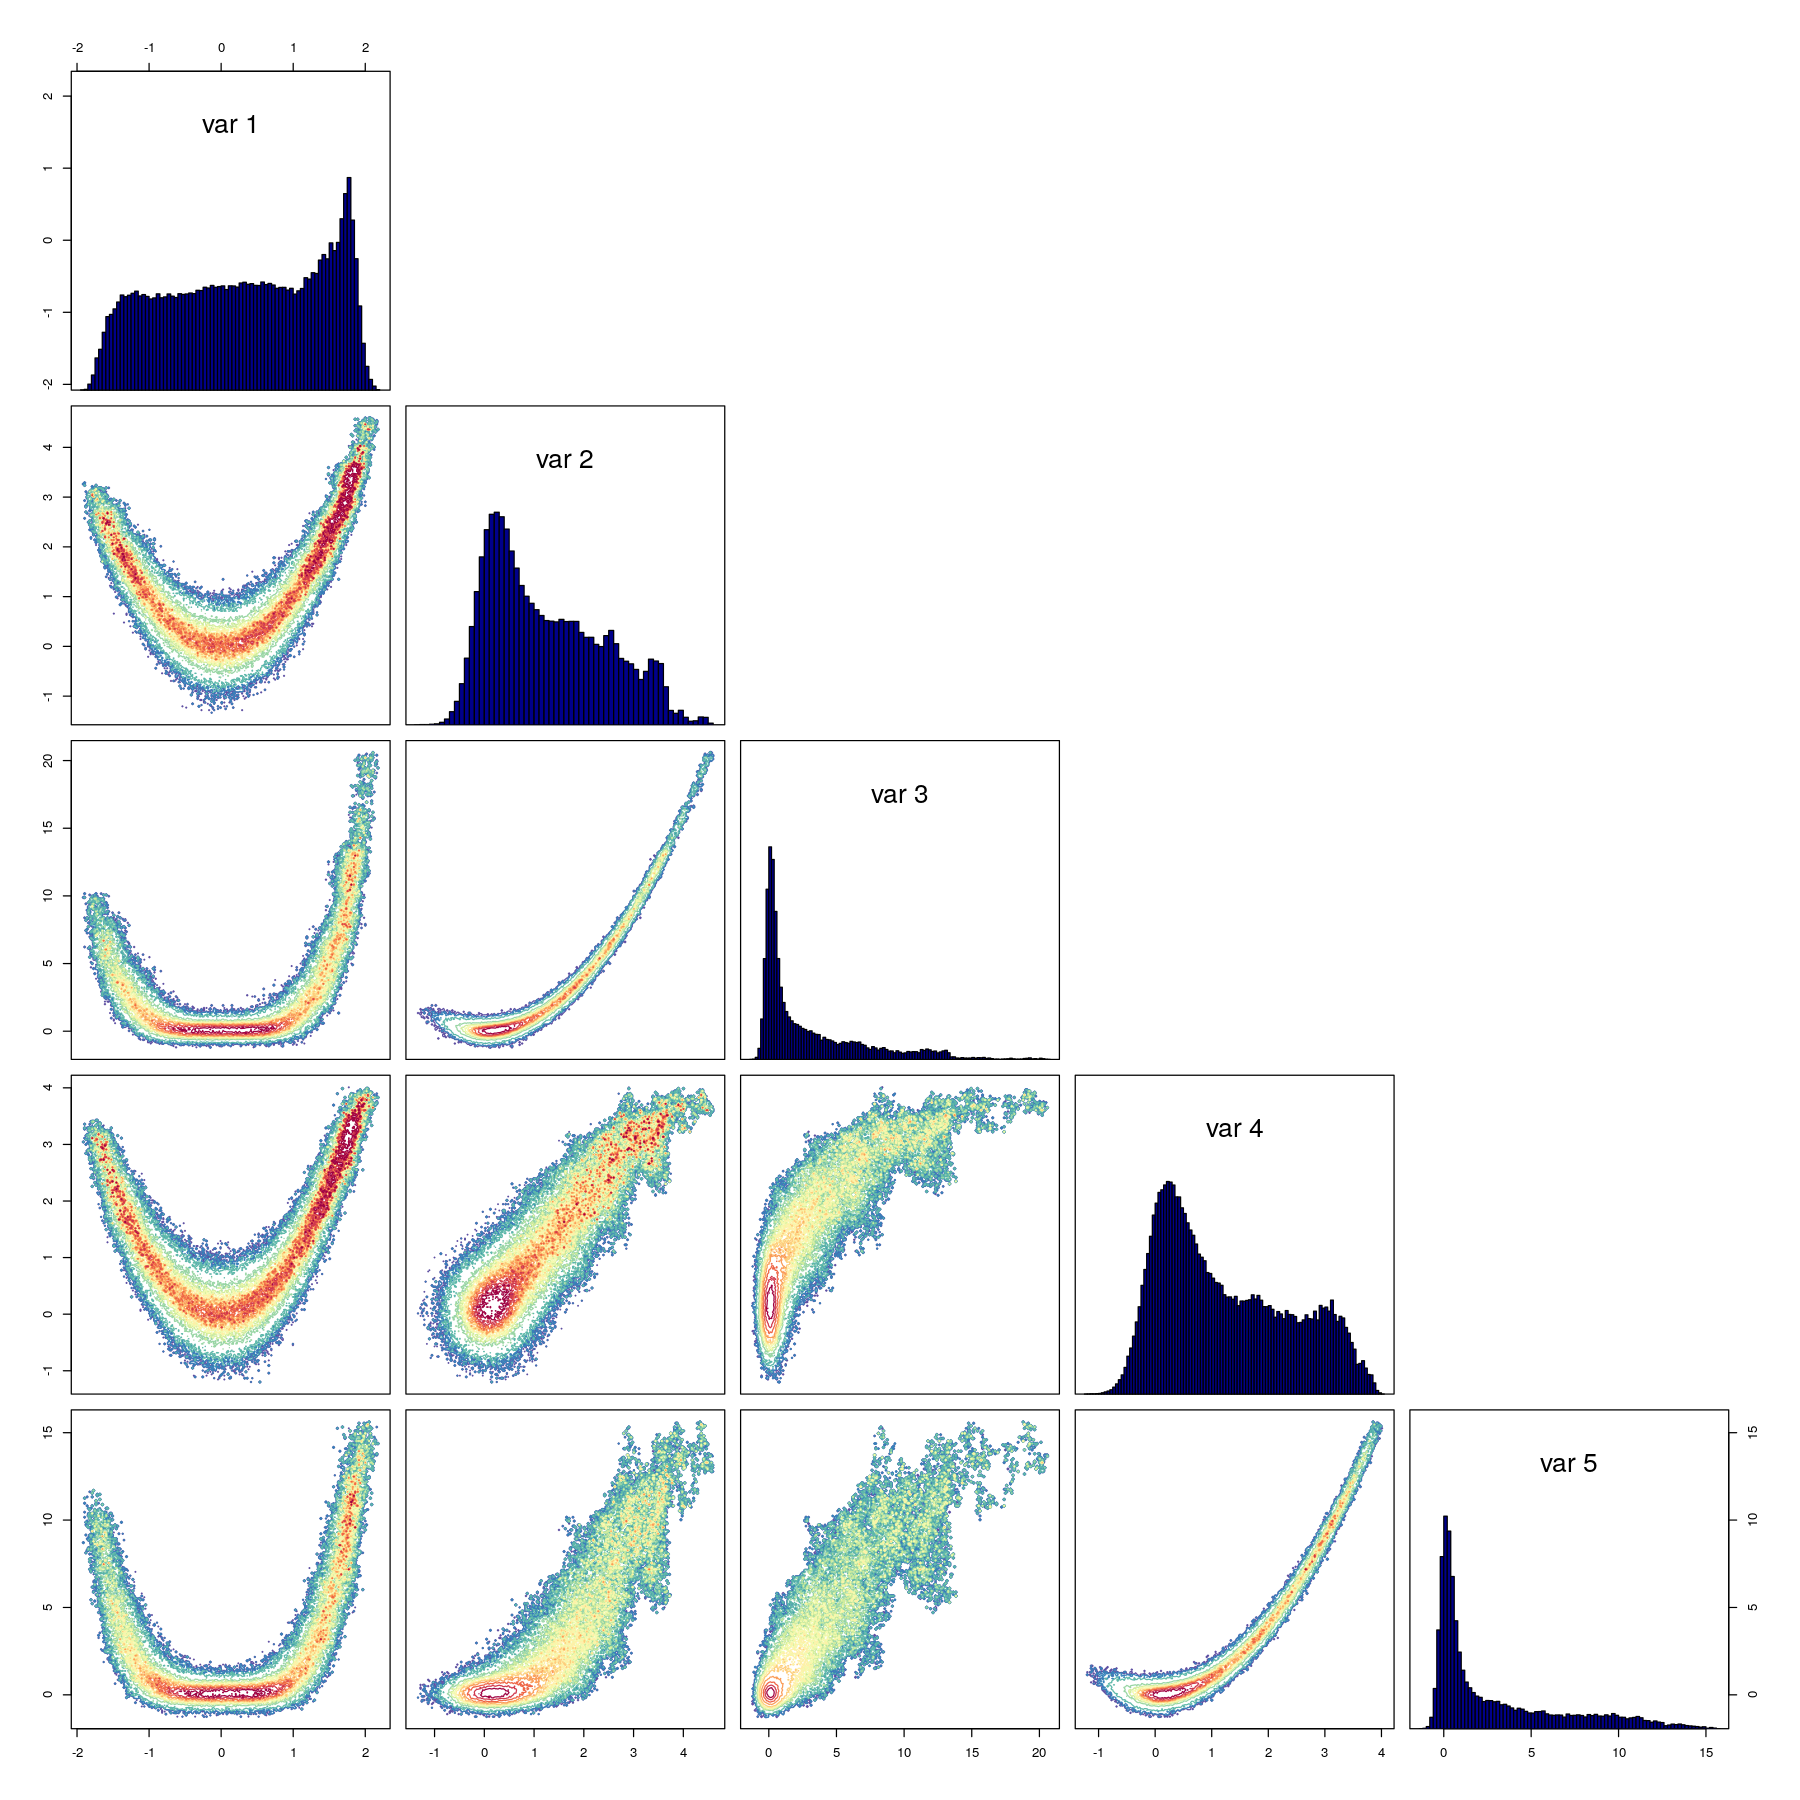

In [18]:
myBetterPairs(resRW[[1]], resol=.1 ) #plot. Careful not to under- or over-smooth.

Without knowing the true shape, it could be said it's doing ok (for a Random Walk), but actually it never really leaves the mode. How to realise that without knowing the solution? Run different, more sophisticated MCMC algorithms, such as Simplified Manifold MALA (sMMALA) and Stan (basically the NUTS algorithm) **IF** you can calculate the gradient and Hessian of your model.

## 3b) Simplified Manifold MALA on the 5d Hybrid Rosenbrock

sMMALA is a clever algorithm that uses the gradient of the target to inform its moves, as well as the local curvature (Hessian). It's designed to work well on this kind of densities.

In [7]:
#### the sMMALA algorithm ####


malaSimplRosenGeneral=function(xi,h,run,alpha, U, gradU, H){
ptm=proc.time()
d=length(xi)

Heb=Hea=eigen(H(xi), symmetric = TRUE);
Lb=La=Hea$values * coth(alpha*Hea$values)
H2b=H2a=Hea$vectors %*% diag( 1/sqrt(La) ) #H^(-1/2)
H1b=H1a=H2a %*% t(H2a) #H^(-1)
H3b=H3a=Hea$vectors %*% diag( La ) %*% t(Hea$vectors) #H

meanGO = xi + h * H1a %*% gradU(xi)/2
meanBACK = 0 #declare vars outside loop ?
Uxi = U(xi)
Uxinew = 0

out=matrix(0,run,d)
count=0
for(n in 1:run){
	if(n%%(run/10)==0) { #track progress1
		cat("Progress:",n/run*100,"% \n") #cat("Iteration n.",n,"\n");
		#if(n==run/10){ time=proc.time()-ptm; cat("Estimated Run Time ",round(time[1]/60 /n*run ,digits=2),"Min","\n" );	}
	}
	
	xinew = meanGO + sqrt(h) * H2a %*% rnorm(d) #first iter const metric

	Heb=eigen(H(xinew), symmetric = TRUE);
	Lb=Heb$values * coth(alpha*Heb$values)
	H2b=Heb$vectors %*% diag( 1/sqrt(Lb) ) #H^-1/2
	H1b=H2b %*% t(H2b) #H^-1
	H3b=Heb$vectors %*% diag( Lb ) %*% t(Heb$vectors) #just H
	
	qlogGO  =1/2*sum(log(La)) - 1/(2*h) * t(xinew - meanGO) %*% H3a %*% (xinew - meanGO)
	
	meanBACK = xinew + h * H1b %*% gradU(xinew)/2
	qlogBACK=1/2*sum(log(Lb)) - 1/(2*h) * t(xi - meanBACK) %*% H3b %*% (xi - meanBACK)
	
	Uxinew=U(xinew)
	
	if( runif(1) < exp( Uxinew - qlogGO - Uxi + qlogBACK  ) ){ 
		xi=xinew
		count=count+1
		
		meanGO=meanBACK
		Uxi=Uxinew
		Hea=Heb
		La=Lb
		H2a=H2b
		H1a=H1b
		H3a=H3b
	}
	
	#if(n%%(run/10)==0) cat("Iteration n.",n,"\n") #track progress1
	out[n,]=xi
}
time=proc.time()-ptm
cat('Run Time',round(time[1]/60,digits=2),'Min','\n')
cat("Acc Rate",count/run,"\n")
#system(paste("echo Acc",count/run))
return(list(out,time[1]))
}

The cell above defines the sMMALA algorithm. The cells below define the target, run it and plot it.

Change h to maintain an acceptance of around 30%. There's no optimal result here, it's just an indication.

In [8]:
U6=function(q) {-a*(q[1]-mu)^2 -b*(q[2] - q[1]^2)^2 -b*(q[3] - q[2]^2)^2 -b*(q[4] - q[1]^2)^2 -b*(q[5] - q[4]^2)^2 } #U=+log
Dx6 = function(q) { 2*a*mu -8*b*q[1]^3 +q[1]*(-2*a + 4*b*q[2] +4*b*q[4]) }
Dy6 = function(q) { 2*b*(q[1]^2 +q[2]*(-1 -2*q[2]^2 +2*q[3]) ) }
Dz6 = function(q) { 2*b*(q[2]^2 -q[3]) }
Du6 = function(q) { 2*b*(q[1]^2 +q[4]*(-1 -2*q[4]^2 +2*q[5]) ) }
Dv6 = function(q) { 2*b*(q[4]^2 -q[5]) }
gradU6 = function(q) {c(Dx6(q), Dy6(q), Dz6(q), Du6(q), Dv6(q) )}
H6 = function(q) {-matrix(c(-2*a -24*b*q[1]^2 +4*b*q[2] +4*b*q[4], 4*b*q[1], 0, 4*b*q[1], 0,
							4*b*q[1], -2*b*(1 +6*q[2]^2 -2*q[3]), 4*b*q[2], 0, 0,
							0, 4*b*q[2], -2*b, 0, 0,
							4*b*q[1], 0, 0, -2*b*(1 +6*q[4]^2 -2*q[5]), 4*b*q[4],
							0, 0, 0, 4*b*q[4], -2*b) ,5,5, byrow = T)}



resMALA = malaSimplRosenGeneral(matrix(1,5,1), h=1.0, run=1e+5, 1e+6, U6, gradU6, H6)

Progress: 10 % 
Progress: 20 % 
Progress: 30 % 
Progress: 40 % 
Progress: 50 % 
Progress: 60 % 
Progress: 70 % 
Progress: 80 % 
Progress: 90 % 
Progress: 100 % 
Run Time 0.19 Min 
Acc Rate 0.31727 


skipped level 0.1 


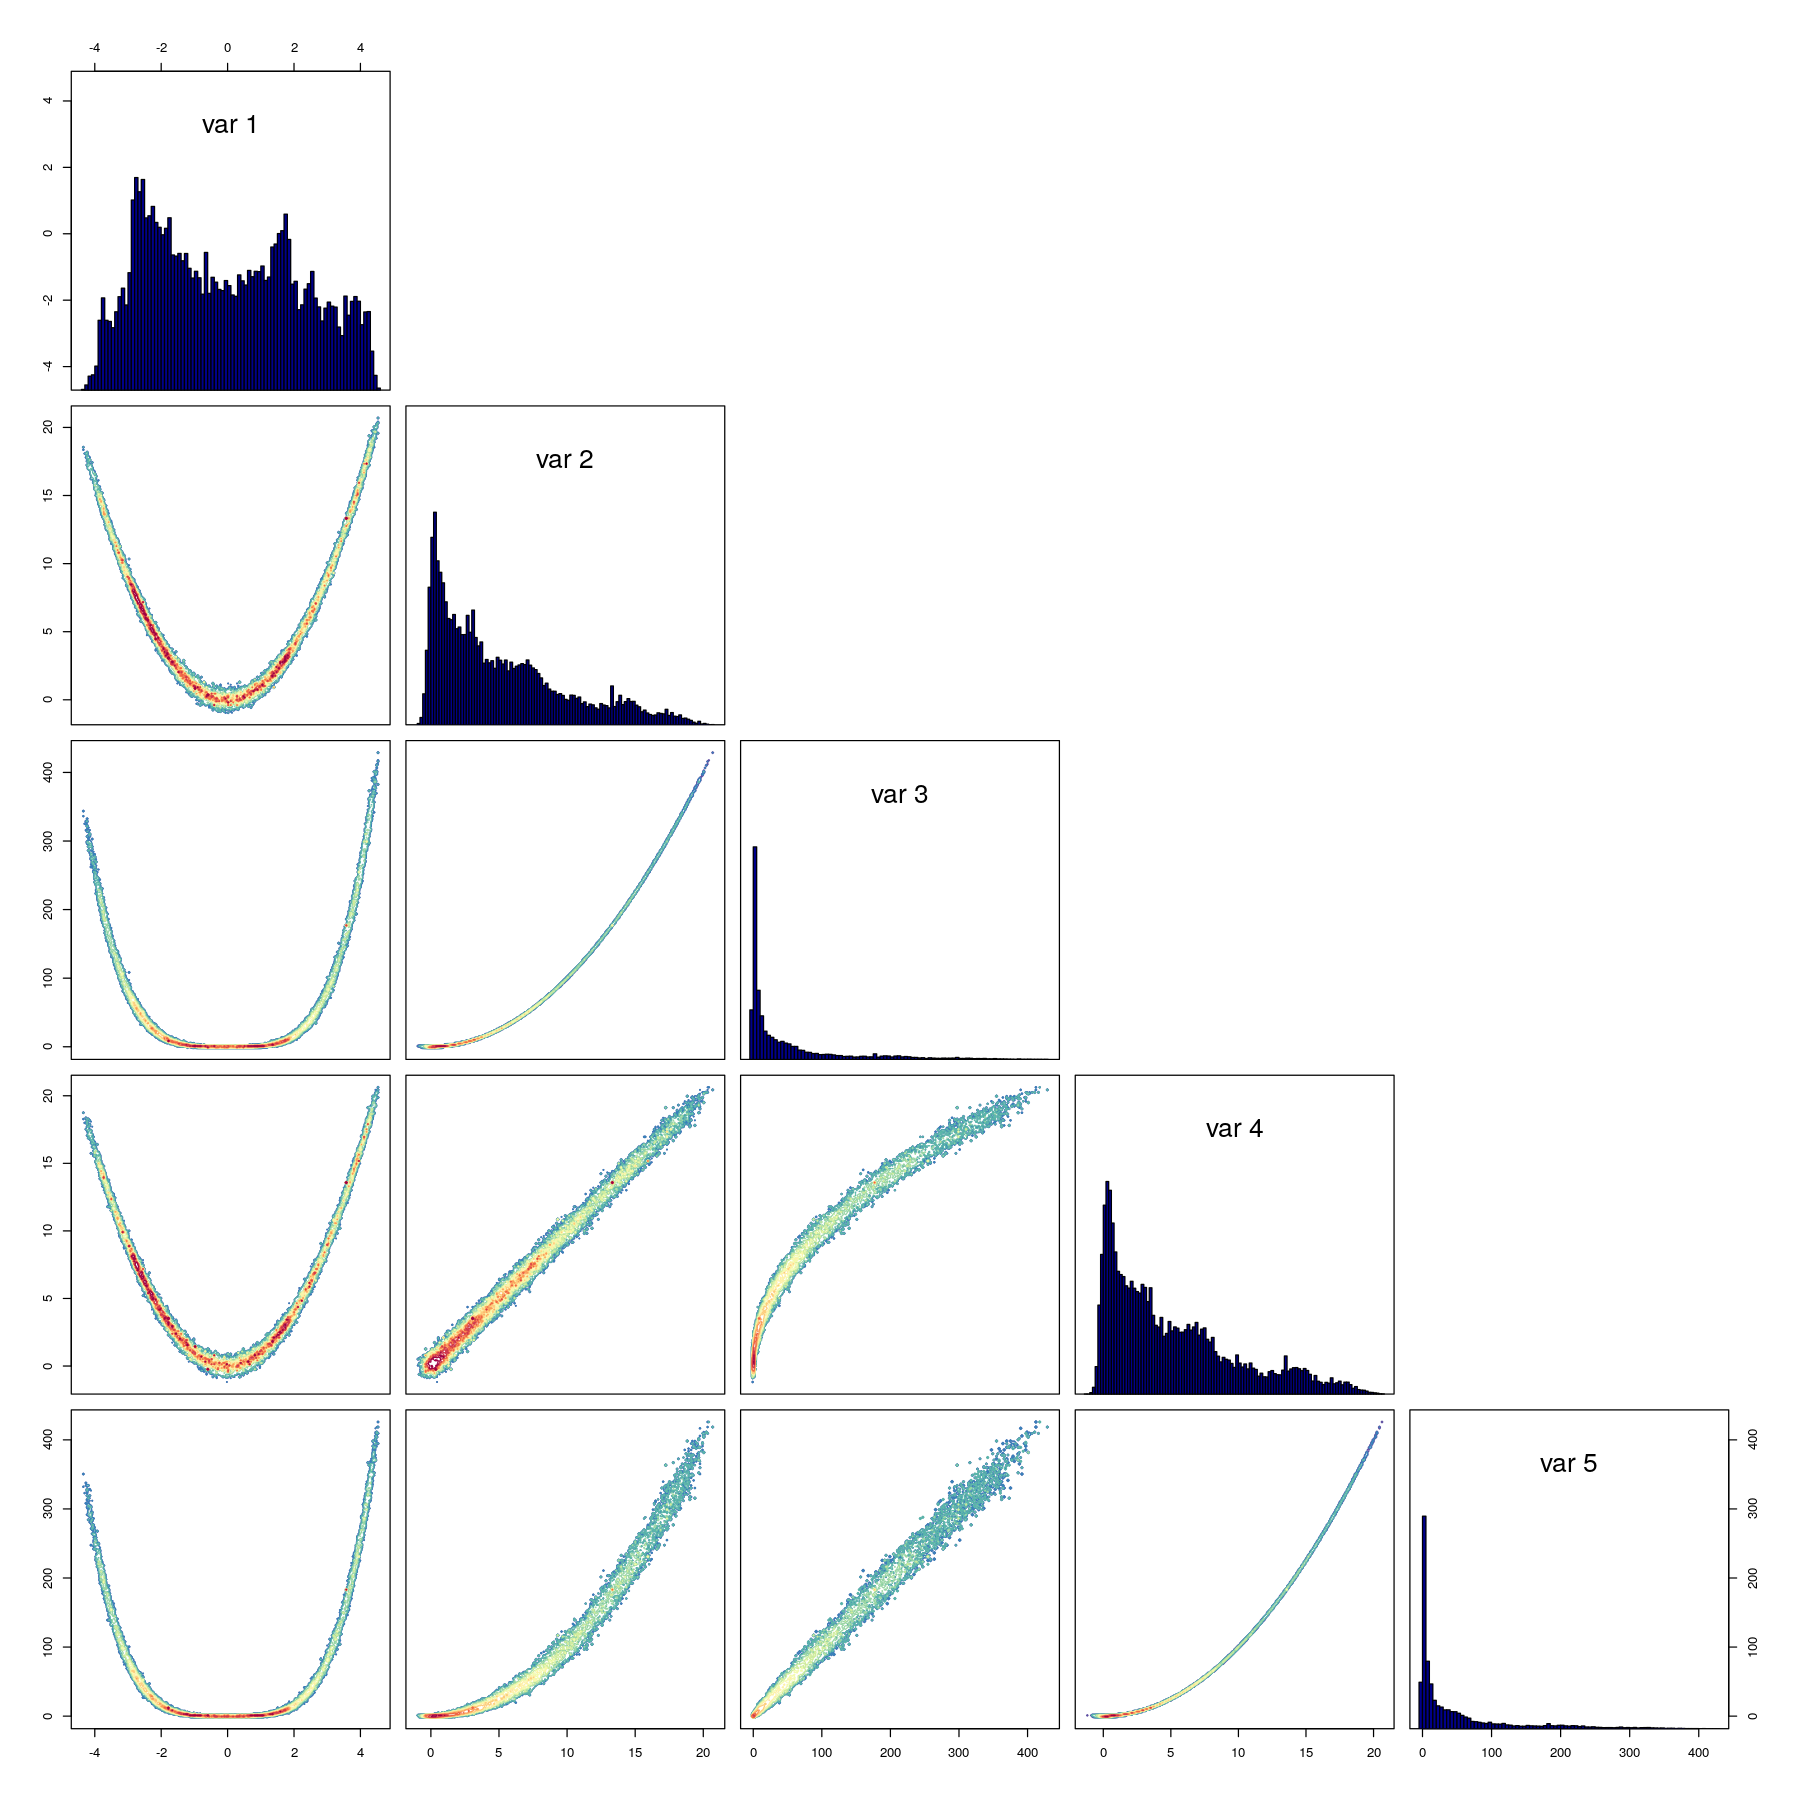

In [25]:
options(warn=-1)
myBetterPairs(resMALA[[1]], resol=.1 ) #plot. Careful not to under- or over-smooth.
options(warn= 0)

Despite the very small samples involved, sMMALA seems to explore the density much better than RWM. 

Below we'll use another smart algorithm, so that you have more than one tool in your toolbox.

## 3c) Stan (No-U-Turn-Sampler) [basically smart HMC] for a 5d Hybrid Rosenbrock

The NUTS algorithm is a smarter version of HMC, where the number of steps per iteration is picked adaptively according to the current trajectory across the target. It basically requires no tuning in all but the most complicated situations. 

Unlike sMMALA, it does not use the local curvature of the target to inform moves, but because of the way the integrator at the core of the algorithm works, it's very flexible.

In [33]:
#### Stan (NUTS, HMC) ####

#this is how you pass a model like ours to stan. 
#the *data* block containes fixed quantities, in our case our parameters.
#the parameters block contains the things you want to estimate, in our case the components of the densitiy.
#in the model block, I had to pass our model as a custom one. Standard one are already coded in Stan.

scode = "
data {
  real mu;
  real<lower=0> a;
  real<lower=0> b;
}
parameters {
  vector[5] q;
}
model {
  target += -( a*(q[1]-mu)^2 + b*(q[2] - q[1]^2)^2 + b*(q[3] - q[2]^2)^2 + b*(q[4] - q[1]^2)^2 + b*(q[5] - q[4]^2)^2 );
}"

fit1 <- stan( model_code = scode, 
           data=list(mu=1, a=1/20, b=100/20), #need to specify parameters here!!
           iter = 20000,
           chains=1, #need to set up cores for parallel separately 
           cores=1, 
           refresh=0, #turn off comments
           verbose=TRUE,
           init=1, 
           algorithm = "NUTS", 
           control=list(metric="diag_e", adapt_delta=.98, max_treedepth=10)
           )

#The warning messages are very useful, but don't worry too much now, 
#because we know the solution and we know that it's a very difficult target. 


TRANSLATING MODEL '659772b12e02f4deb5dc07b60f4d9598' FROM Stan CODE TO C++ CODE NOW.
successful in parsing the Stan model '659772b12e02f4deb5dc07b60f4d9598'.

CHECKING DATA AND PREPROCESSING FOR MODEL '659772b12e02f4deb5dc07b60f4d9598' NOW.

COMPILING MODEL '659772b12e02f4deb5dc07b60f4d9598' NOW.

STARTING SAMPLER FOR MODEL '659772b12e02f4deb5dc07b60f4d9598' NOW.


Warning message:
“There were 2607 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


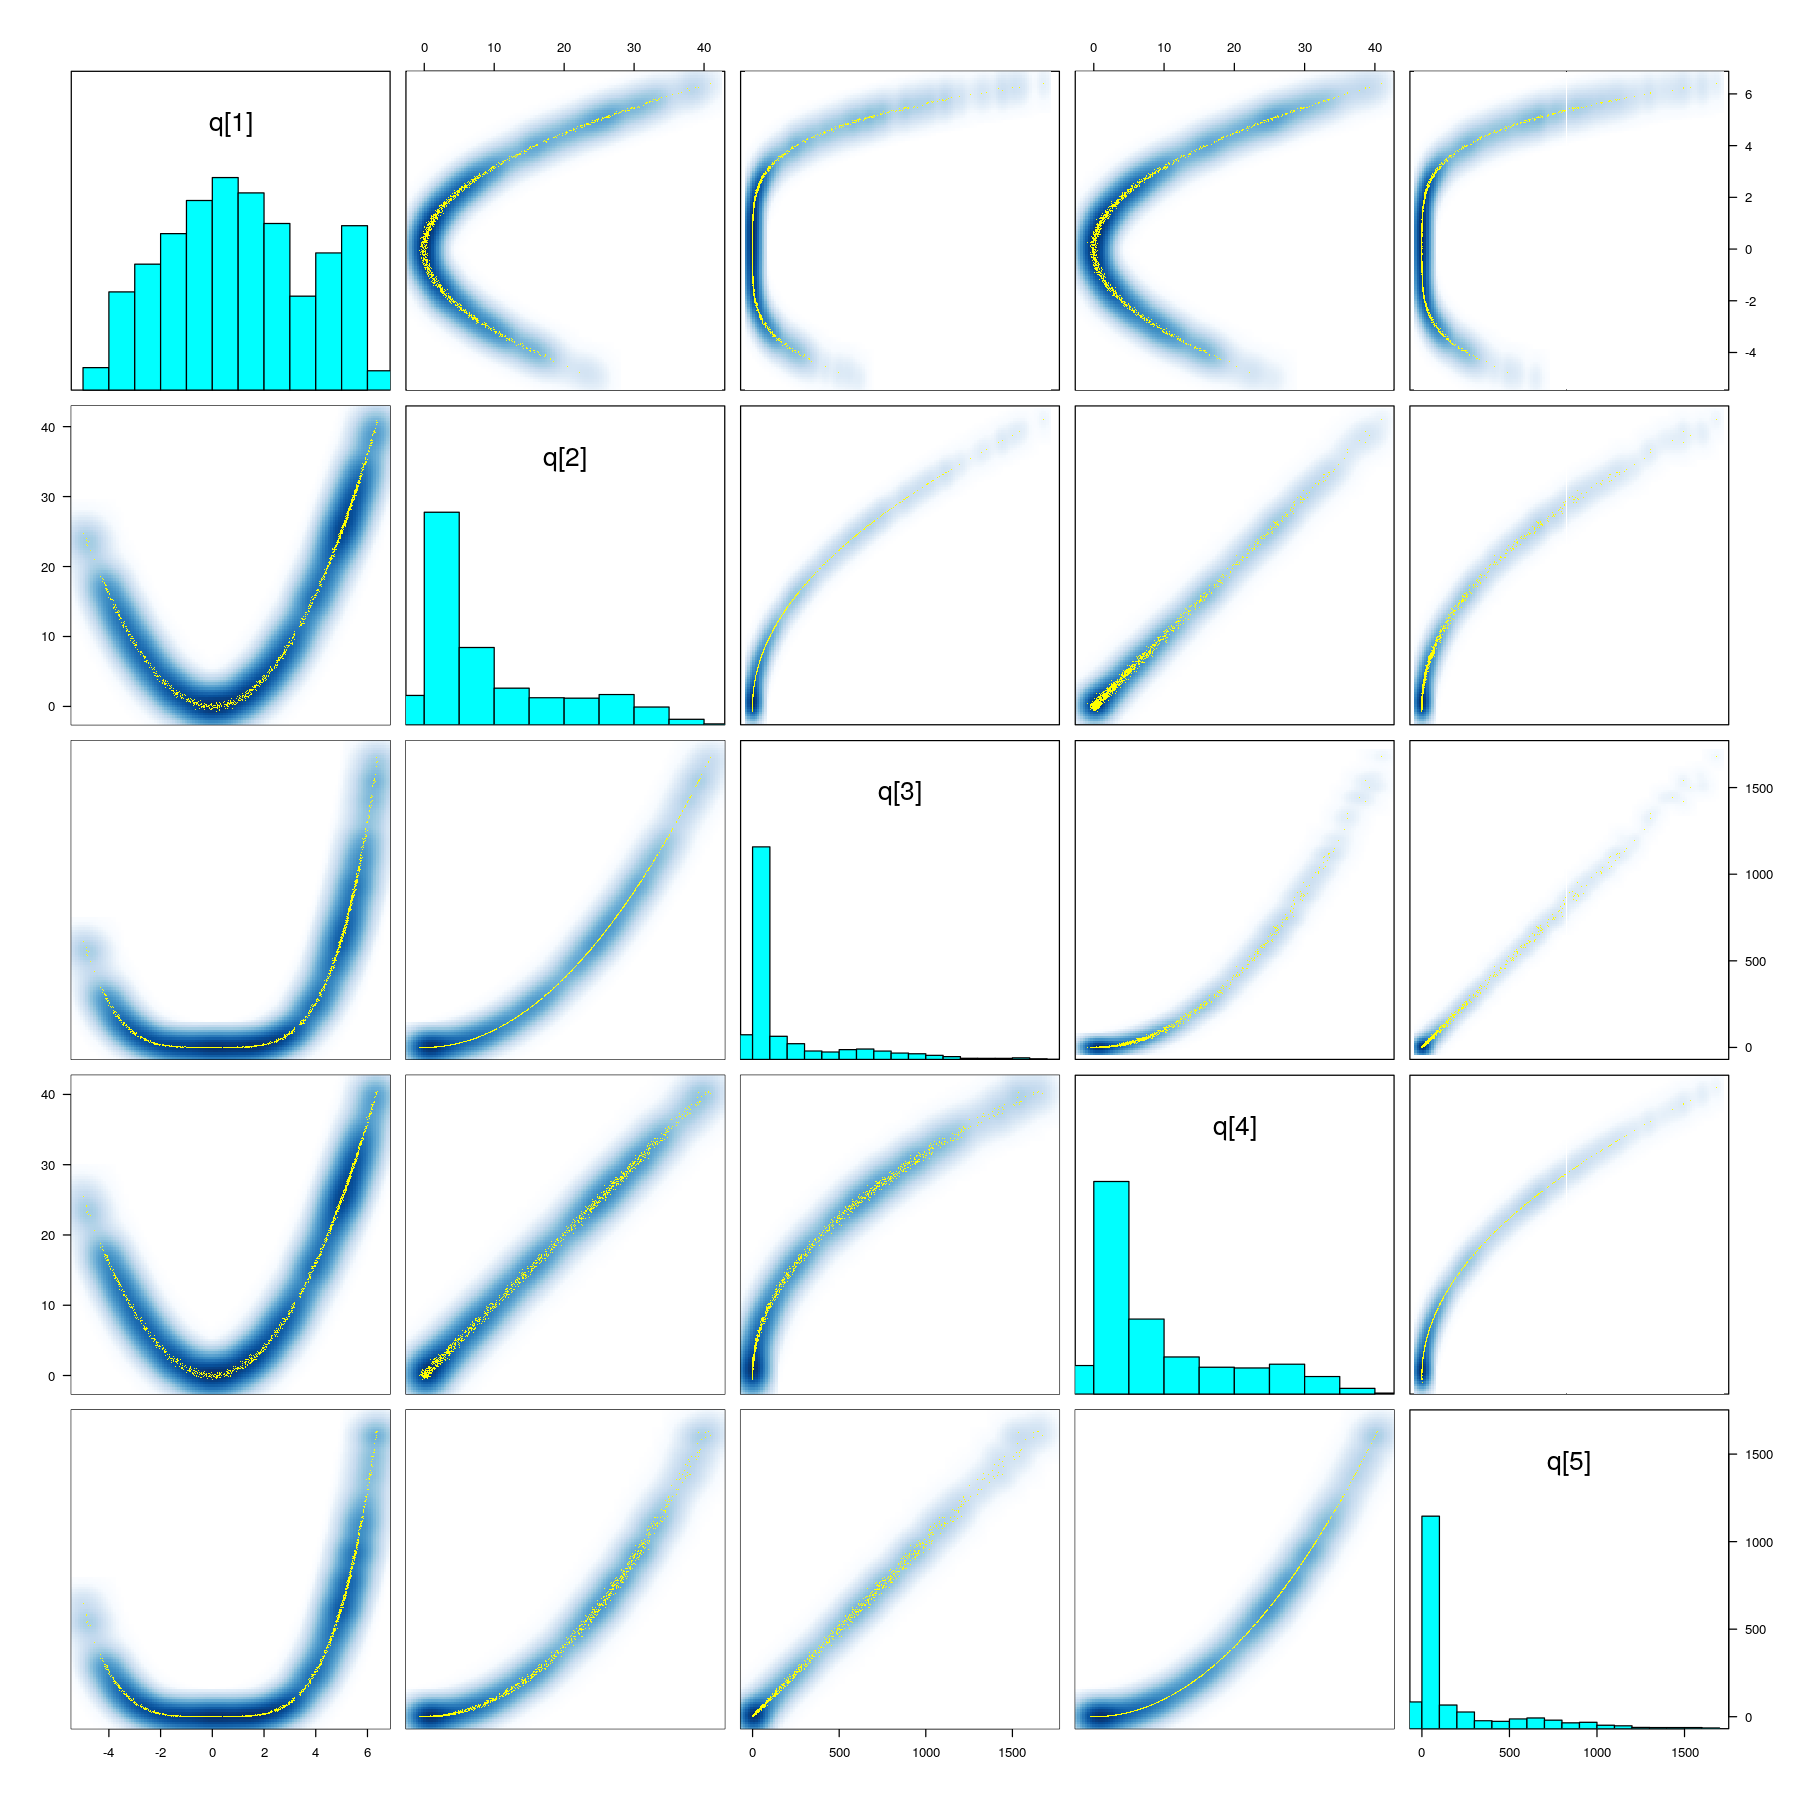

In [34]:
pairs(fit1, pars = c("q"), las = 1) #pairs() function is overloaded for a stan fit object.

## these are other useful commands for Stan ##
#e <- extract(fit1) # return a list of arrays
#print(names(e))
#sampler_params <- get_sampler_params(fit1, inc_warmup = FALSE)

Stan does automatic differentiation, and the default settings are fairly good.

If it's hard to write your model in the Stan syntax, and/or it's hard to derive the gradient and Hessian (even for Stan sometimes), then you have a problem.

What you can do is 
1. take the Hybrid Rosenbrock distribution 
2. tweak the shape as showed in the initial part of the notebook, to make it similar to the shape of your problem
3. run your favourite MCMC method on it
4. see how biased the results are
5. *either* tell the reviewers that you've checked and it's ok, *or* move on to a more advanced algorithm.